## Figures for thesis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import json
import glob
import pickle
from aif360.sklearn.metrics import statistical_parity_difference, disparate_impact_ratio, \
    average_odds_difference, equal_opportunity_difference

In [2]:
# directory management
wdir = os.getcwd()
udir = os.path.join(os.path.split(wdir)[0], "utils")
ddir = os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_data", "rawdata")
ddir2 = os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_data", "aggregated")
fdir = os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_figures")
if not os.path.exists(fdir):
  # Create a figures directory because it does not exist
  os.makedirs(fdir)
  print("Figures directory has been created!")

json_file_path = os.path.join(udir,'tasks_metadata.json')
with open(json_file_path, 'r') as j:
    task_infos = json.loads(j.read())

### Prepare task specific aggregated files if not existent already

In [3]:
data_fn = {}

for task in task_infos["task_names"]:
    data_fn[task] = {}
    for year_path in glob.iglob(f'{ddir}\*'):
        data_fn[task][str(os.path.split(year_path)[1])] = []
        year_path_1year = year_path + r'\1-Year'
        for state_path in glob.iglob(f'{year_path_1year}\*'):
            if state_path.endswith(f"{task}.csv"):
                data_fn[task][str(os.path.split(year_path)[1])].append(state_path)


### Explore frequency of NaN values and possible ways of recoding them

In [10]:
df = pd.read_csv(data_fn['ACSHealthInsurance']['2014'][0])
df['RAC1P'] = df[['RACAIAN', 'RACASN','RACBLK', 'RACNH', 'RACPI', 'RACSOR', 'RACWHT']].idxmax(axis=1)
race_codes = {'RACAIAN':5, 'RACASN':6, 'RACBLK':2, 'RACNH':7, 'RACPI':7, 'RACSOR':8, 'RACWHT':1}
df['RAC1P'] = df['RAC1P'].map(race_codes)
df.drop(['RACAIAN', 'RACASN','RACBLK', 'RACNH', 'RACPI', 'RACSOR', 'RACWHT'], axis=1, inplace=True)
df.head(20)

,Unnamed: 0,AGEP,SCHL,MAR,SEX,DIS,ESP,CIT,MIG,MIL,...,NATIVITY,DEAR,DEYE,DREM,PINCP,ESR,ST,FER,HINS2,RAC1P
0,0,30.0,19.0,1.0,2.0,2.0,0.0,4.0,1.0,4.0,...,2.0,2.0,2.0,2.0,900.0,6.0,2.0,2.0,0.0,1
1,1,34.0,20.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,49760.0,1.0,2.0,0.0,0.0,1
2,2,7.0,3.0,5.0,2.0,2.0,2.0,1.0,1.0,0.0,...,1.0,2.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,1
3,3,5.0,2.0,5.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,2.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,1
4,4,4.0,1.0,5.0,2.0,2.0,2.0,1.0,1.0,0.0,...,1.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1
5,5,52.0,19.0,1.0,2.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,900.0,6.0,2.0,0.0,0.0,1
6,6,52.0,19.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,60900.0,1.0,2.0,0.0,0.0,1
7,7,28.0,18.0,5.0,1.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,1900.0,1.0,2.0,0.0,0.0,1
8,8,38.0,21.0,1.0,2.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,105000.0,1.0,2.0,2.0,0.0,1
9,9,38.0,18.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,140000.0,1.0,2.0,0.0,0.0,1


### Create files for the three tasks concatenating all states and years

In [10]:
for task in task_infos["task_names"]:

    if not os.path.exists(os.path.join(ddir2, task)):
        print(f"Preparing task {task}")
        os.makedirs(os.path.join(ddir2, task))
        print(f"Folder for aggregated task data {os.path.join(ddir2, task)} created!")
        dfs = []
        for year_to_plot in task_infos["years"]:
            all_dfs = []
            for data_path in data_fn[task][str(year_to_plot)]:
                state_df = pd.read_csv(data_path,sep=',',header=0)
                state_df['STATE'] = os.path.split(data_path)[1][5:7]
                all_dfs.append(state_df)
            year_df = pd.concat(all_dfs, ignore_index=True)
            year_df['YEAR']=int(year_to_plot)
            dfs.append(year_df)

    final_df = pd.concat(dfs, ignore_index=True)
    final_df.to_csv(os.path.join(ddir2, task,f'{task}.csv'),sep='\t')

Preparing task ACSEmployment
Folder for aggregated task data C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis_data\aggregated\ACSEmployment created!
Preparing task ACSHealthInsurance
Folder for aggregated task data C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis_data\aggregated\ACSHealthInsurance created!
Preparing task ACSIncome
Folder for aggregated task data C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis_data\aggregated\ACSIncome created!


ValueError: No objects to concatenate

## Plots

### Distribution of age across states for each year

In [3]:
task='ACSEmployment'
df1 = pd.read_csv(os.path.join(ddir2,task,f'{task}.csv'),sep='\t',index_col=0)

#y=2014
#df1=df1[df1['YEAR']==y]
df1.loc[df1['RAC1P'] > 2, 'RAC1P'] = 3

# now recode just for plots
df1.loc[df1['RAC1P'] == 1, 'RAC1P'] = 'White'
df1.loc[df1['RAC1P'] == 2, 'RAC1P'] = 'Black'
df1.loc[df1['RAC1P'] == 3, 'RAC1P'] = 'Other'
df1.loc[df1['SEX'] == 1, 'SEX'] = 'Male'
df1.loc[df1['SEX'] == 2, 'SEX'] = 'Female'

# now exclude puerto rico and keep only advised age range
df1 = df1[(df1['AGEP'].between(16,90)) & (df1['STATE']!='PR')]

#g = sns.displot(data=df1[df1['AGEP']>=16], x="AGEP", hue="RAC1P", col="STATE",col_wrap=5,
#    kind="hist",element="step",discrete=True,stat='density',common_norm=False,
#                legend=True, height=4, aspect=.7,palette= ['#476C9B','#984447','#469978'])

In [4]:
df1['SEX'].unique()

array(['Female', 'Male'], dtype=object)

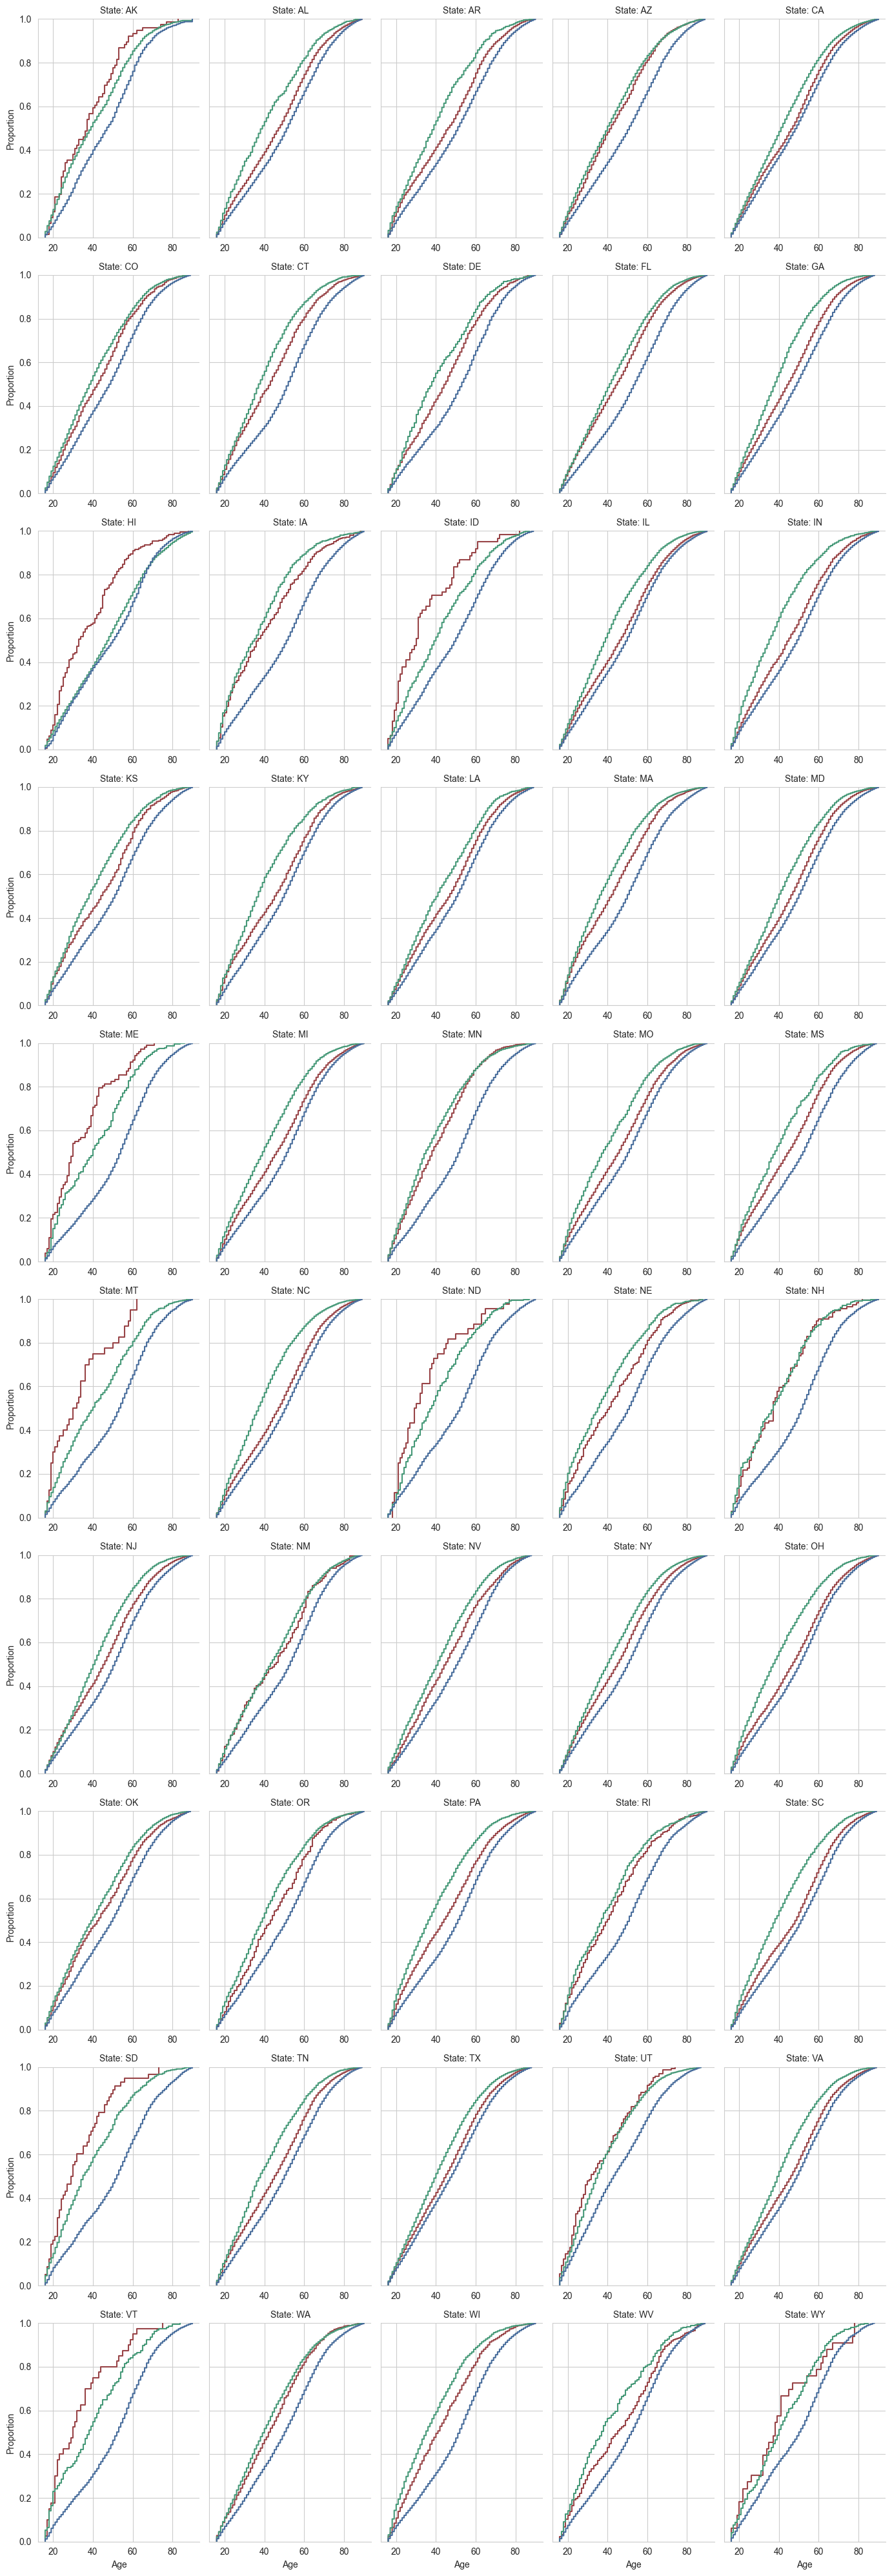

In [41]:
y = 2014

g = sns.displot(data=df1[df1['YEAR']==y], x="AGEP", hue="RAC1P", col="STATE",
                col_wrap=5,kind="ecdf",stat='proportion',legend=False, height=4, aspect=.7,
               palette= {'White':'#476C9B','Black':'#984447','Other':'#469978'})
#g.set_axis_labels("Age","Proportion")
g.set_titles("State: {col_name}")
for ax in g.axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("Age")
    ax.set_ylabel("Proportion")
    plt.subplots_adjust(bottom=0.5,hspace=0.5)
plt.tight_layout()
plt.savefig(os.path.join(fdir,task,f'AGEP_distribution_dependent_on_RAC1P_{task}_{y}.pdf'),format='pdf',dpi=300)

### Class counts as a function of sex and race over the years - ACSEmployment

In [6]:
df1.loc[df1['ESR'] == 1, 'ESR'] = 'Employed'
df1.loc[df1['ESR'] == 0, 'ESR'] = 'Not Employed'
df1.groupby(by=['YEAR','STATE','SEX','RAC1P'])['ESR'].value_counts(normalize=True).to_frame('Proportion (%)')\
    .reset_index()

,YEAR,STATE,SEX,RAC1P,ESR,Proportion (%)
0,2014,AK,Female,Black,Not Employed,0.600000
1,2014,AK,Female,Black,Employed,0.400000
2,2014,AK,Female,Other,Employed,0.503421
3,2014,AK,Female,Other,Not Employed,0.496579
4,2014,AK,Female,White,Employed,0.579300
...,...,...,...,...,...,...
2995,2018,WY,Male,Black,Not Employed,0.153846
2996,2018,WY,Male,Other,Employed,0.515625
2997,2018,WY,Male,Other,Not Employed,0.484375
2998,2018,WY,Male,White,Employed,0.617801


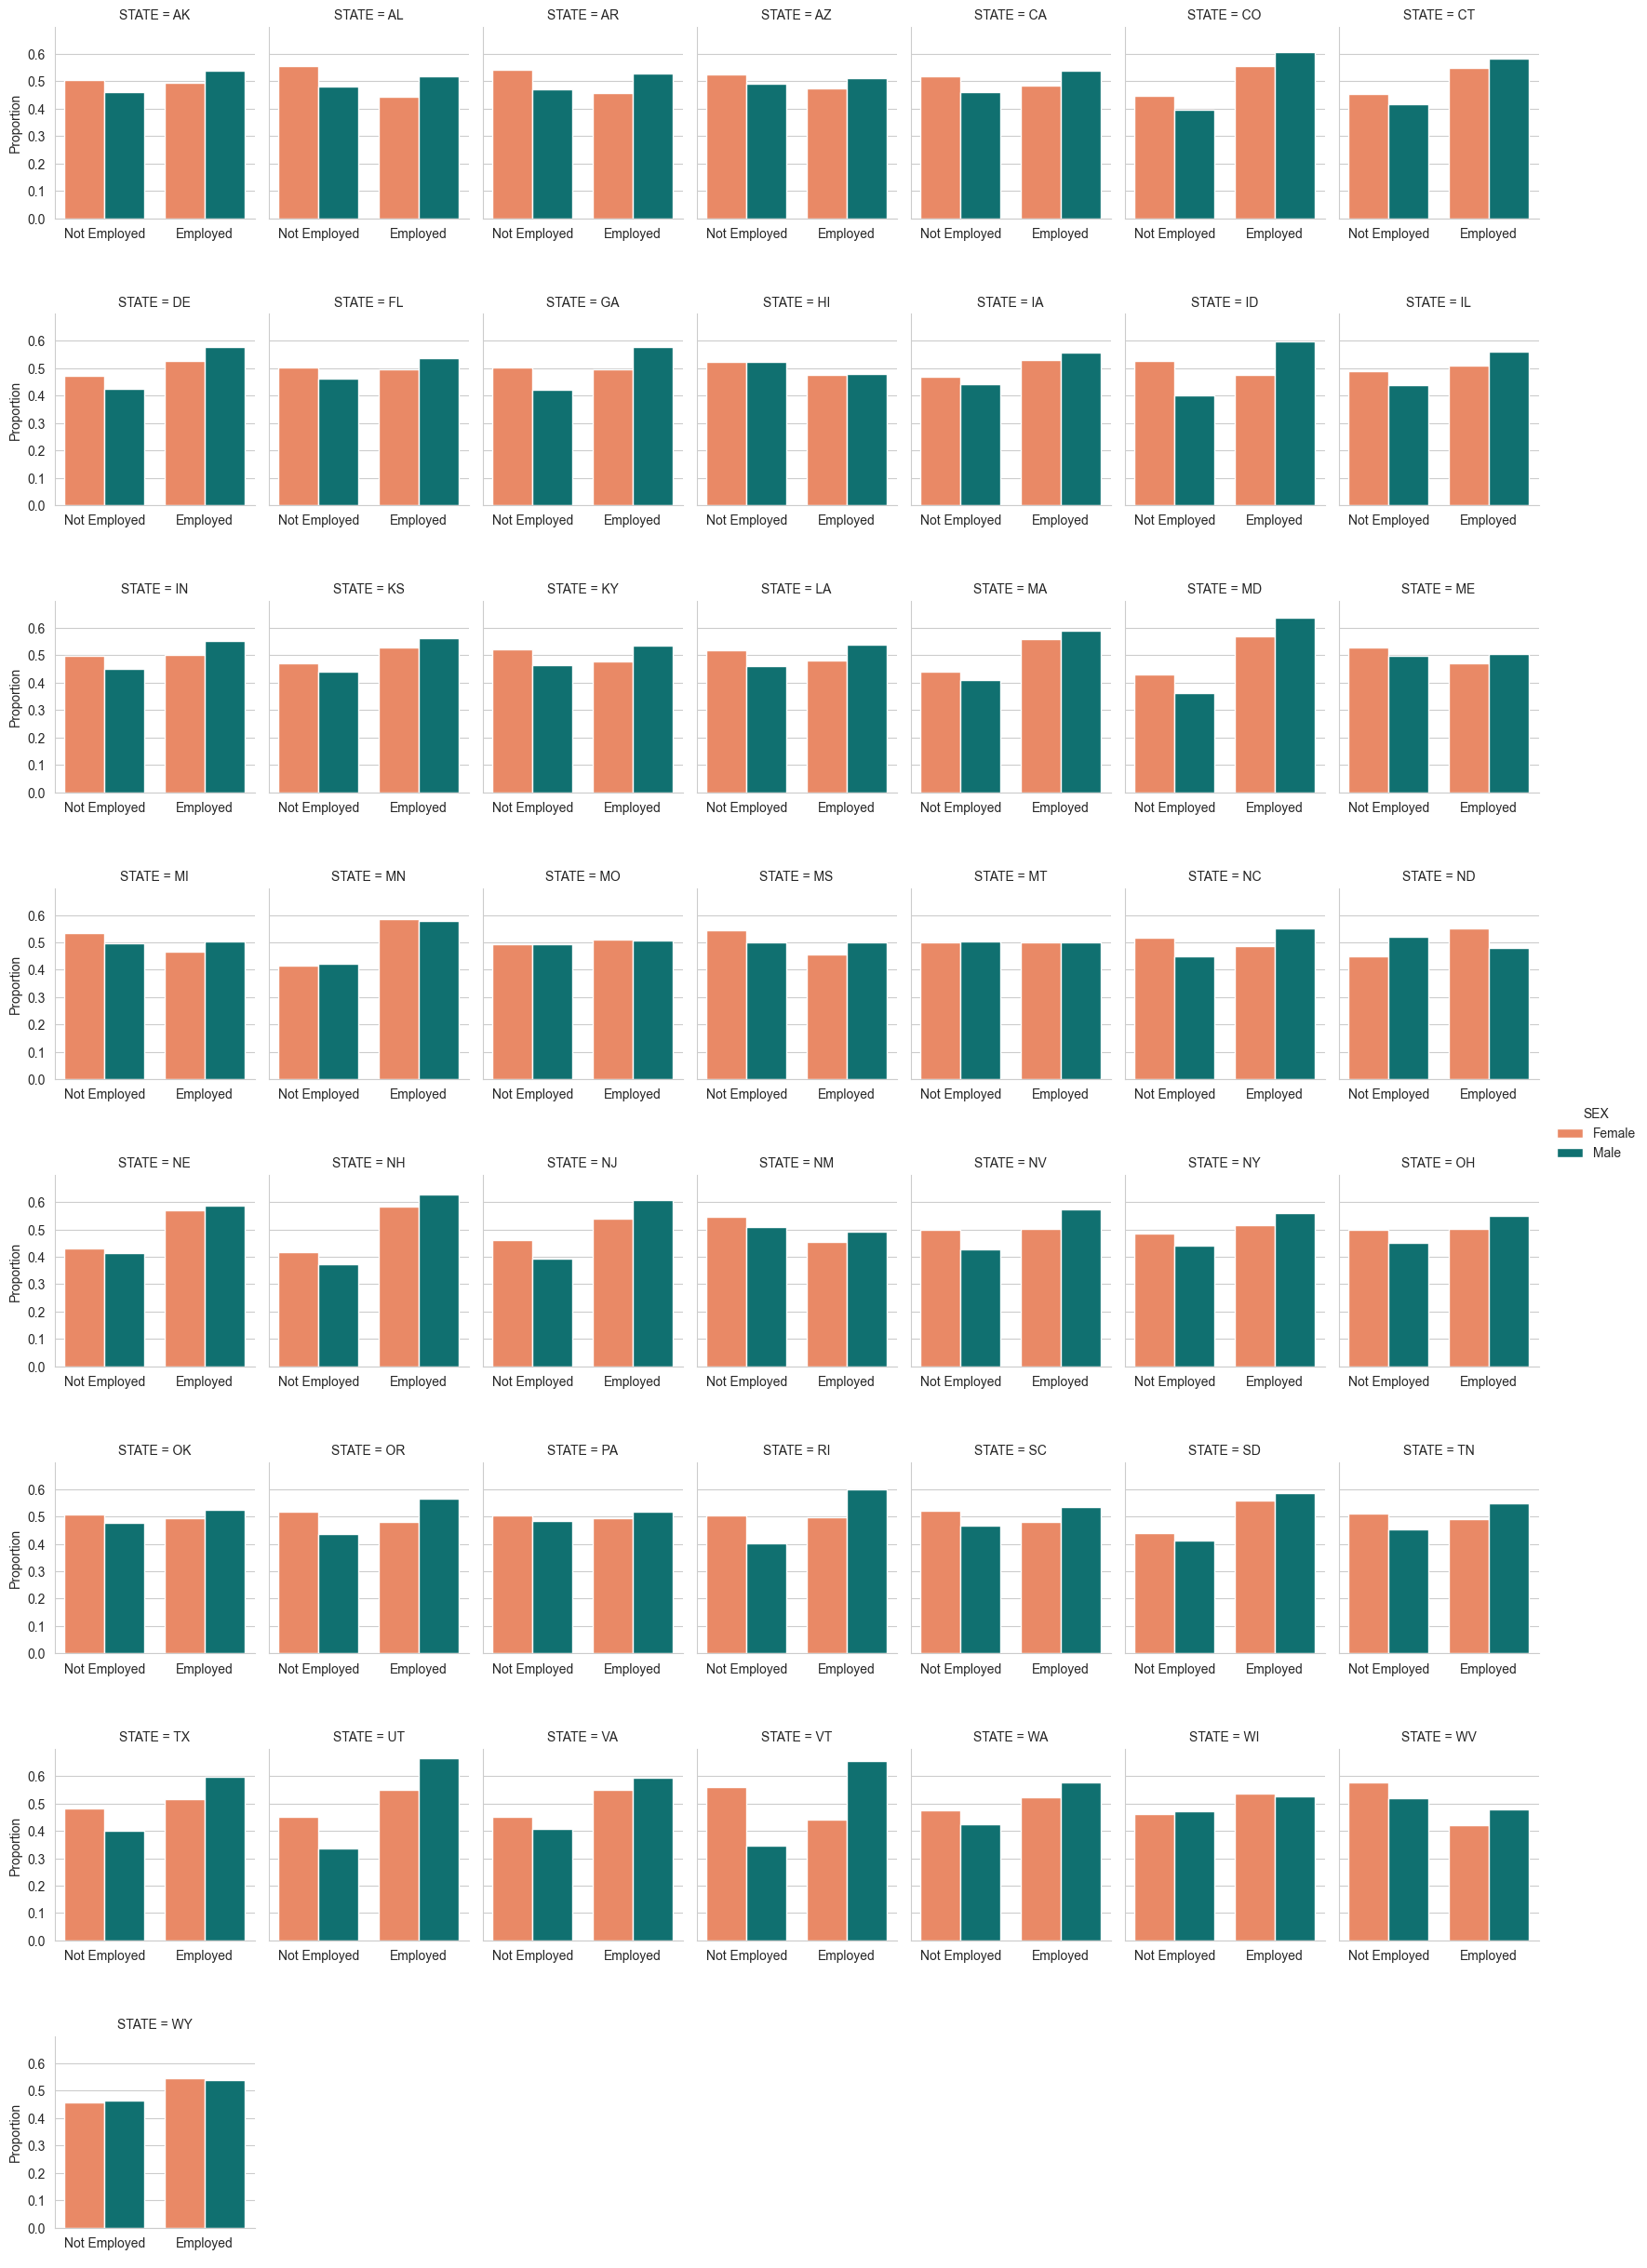

In [17]:
# create a plot for all states
#for task in task_infos["task_names"]:
#    task_data = pd.read_csv(os.path.join(ddir2, task, f"{task}.csv"),sep="\t")
#    task_data.loc[task_data['RAC1P']>2,'RAC1P']=3
#    sns.catplot(data=task_data, x="ESR", hue="SEX",row="RAC1P", col="YEAR",kind="count", height=4, aspect=.6)
y=2014
esr_df = df1.groupby(by=['YEAR','STATE','SEX','RAC1P'])['ESR'].value_counts(normalize=True).to_frame('Proportion').reset_index()
g = sns.catplot(data=esr_df[esr_df['YEAR']==2014], x="ESR",y='Proportion', hue="SEX", col="STATE",col_wrap=7,kind="bar",
            errorbar=None,
            height=6,palette={'Female': 'coral', 'Male': 'teal'}, aspect=.4) #4,0.6
for ax in g.axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("")
    ax.set_ylabel("Proportion")
    plt.subplots_adjust(bottom=0.5,hspace=0.5)
plt.savefig(os.path.join(fdir,task,f'ESR_distribution_dependent_on_SEX_{task}_{y}.pdf'),format='pdf',dpi=300)

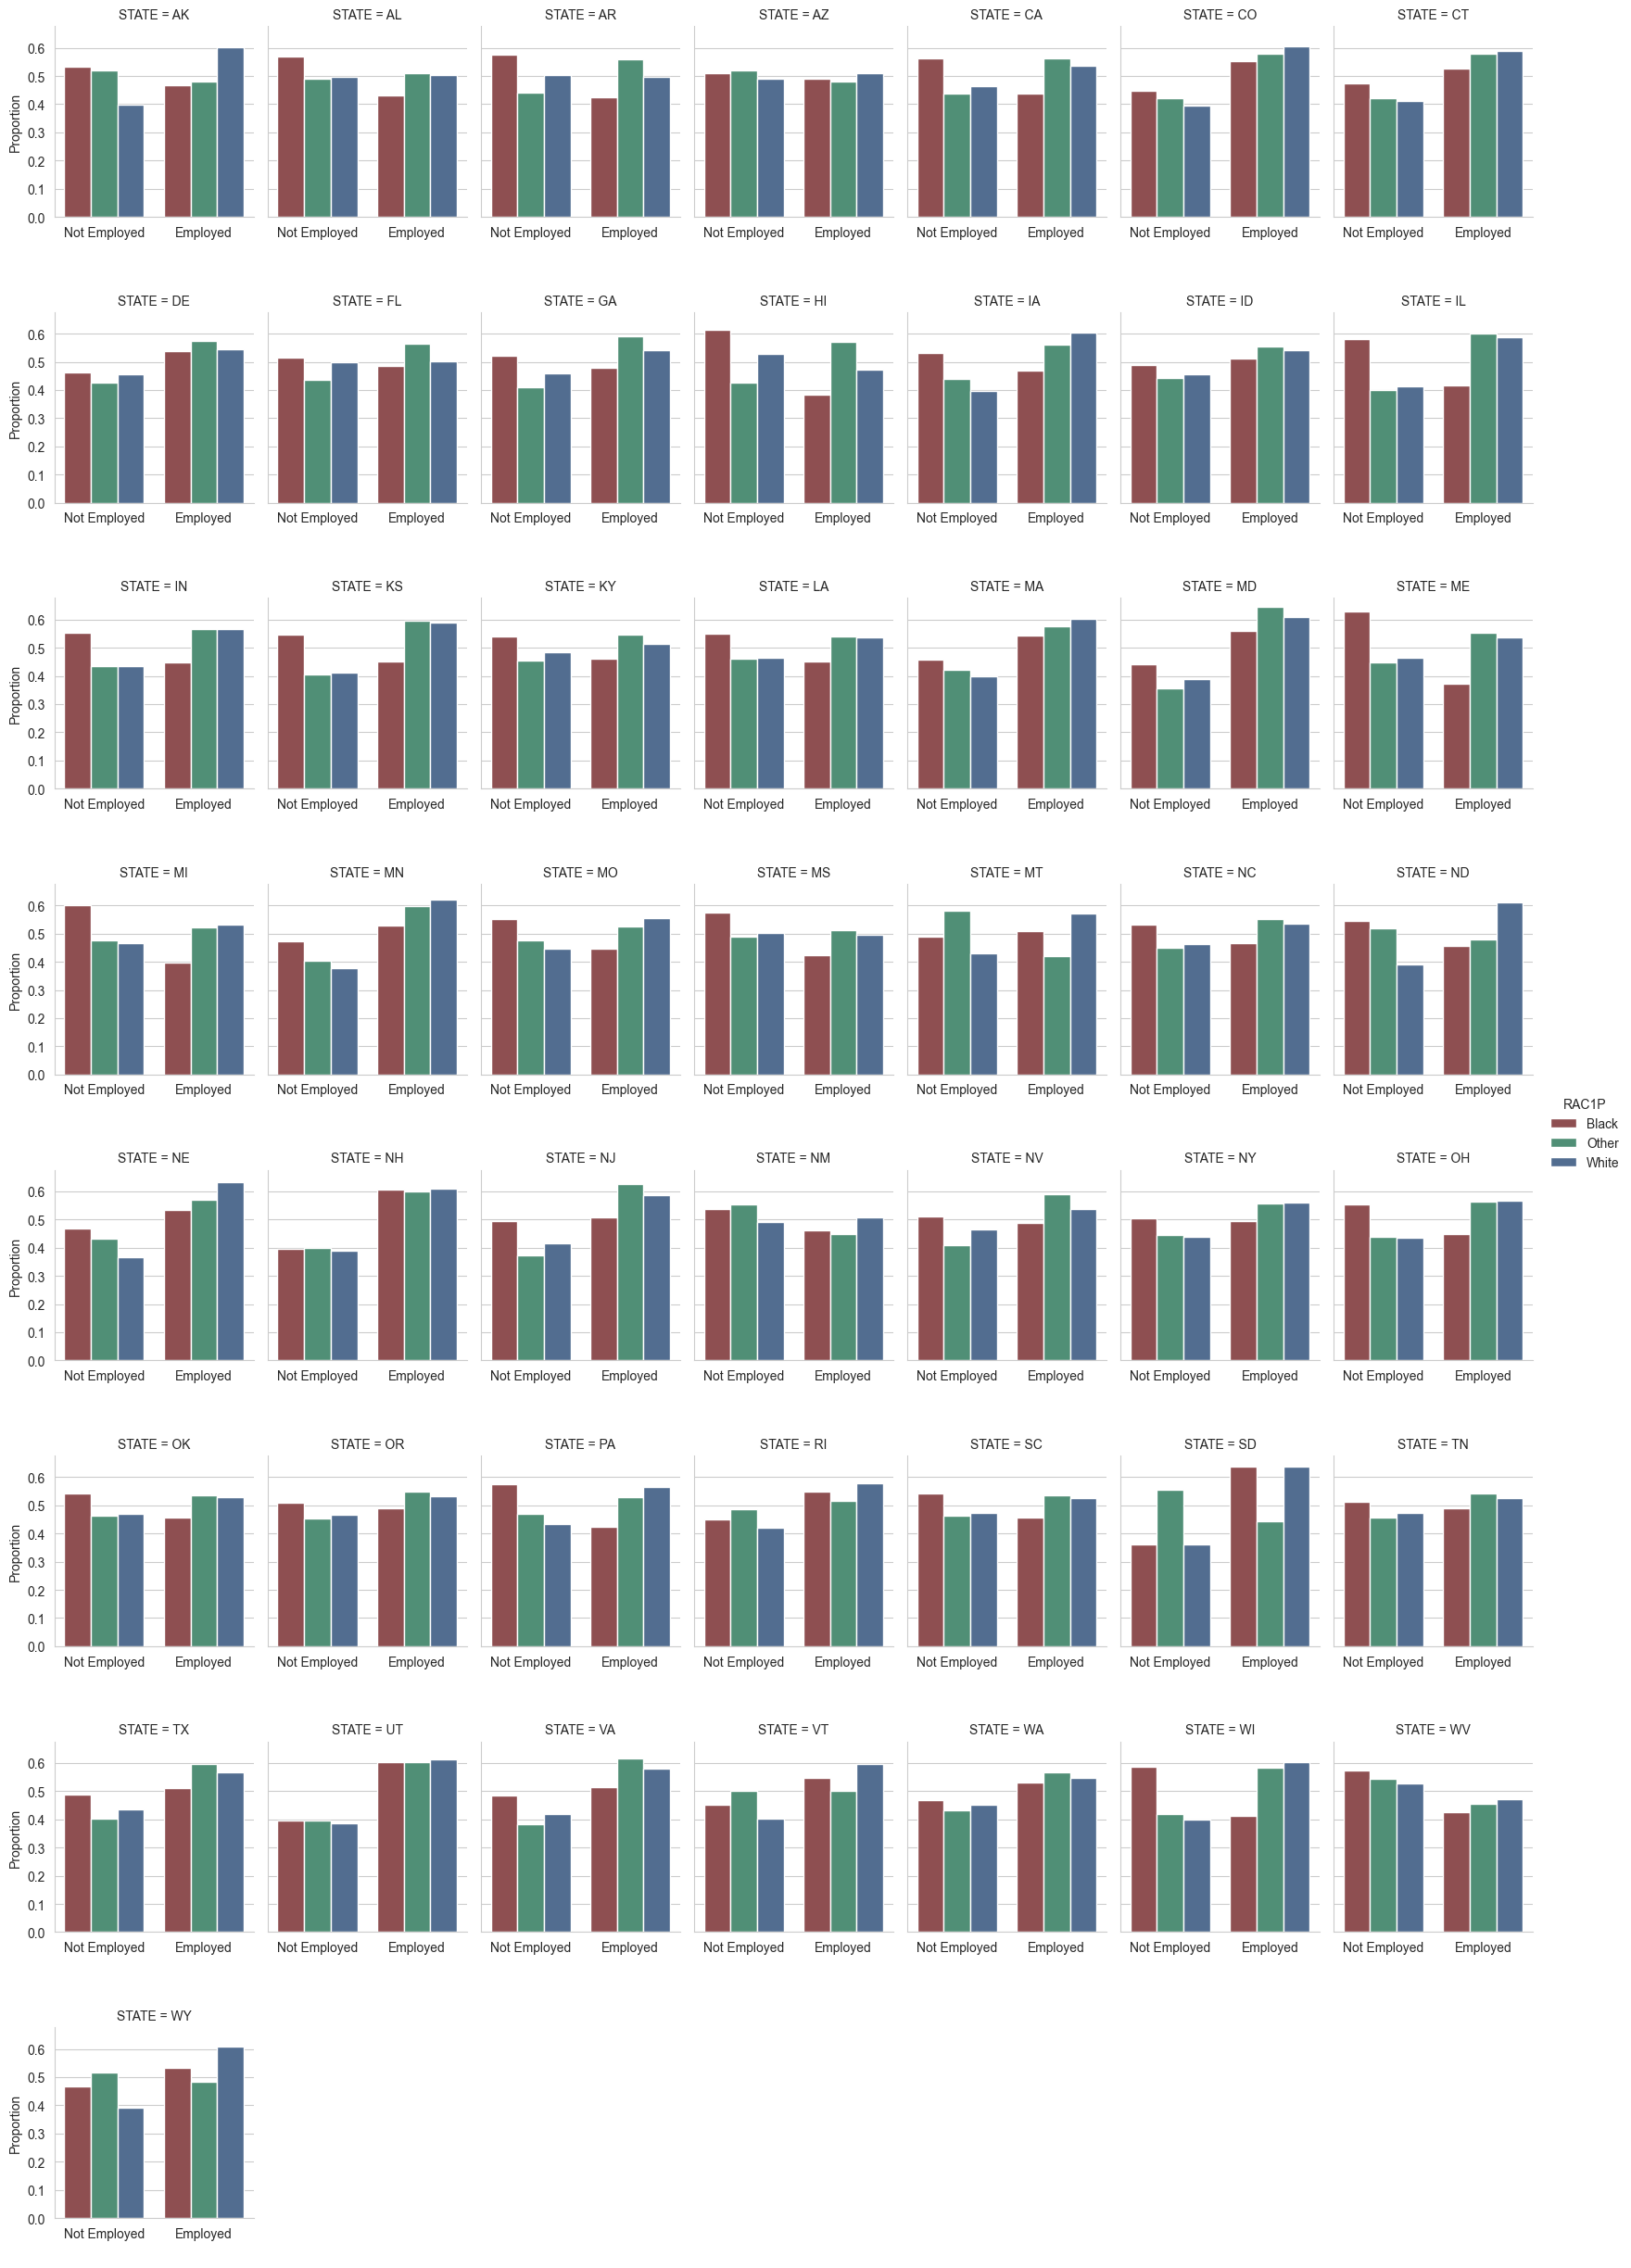

In [18]:
g = sns.catplot(data=esr_df[esr_df['YEAR']==2014], x="ESR",y='Proportion', hue="RAC1P", col="STATE",col_wrap=7,
            kind="bar",
            errorbar=None,
            height=6,palette={'White':'#476C9B','Black':'#984447','Other':'#469978'}, aspect=.4)
for ax in g.axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("")
    ax.set_ylabel("Proportion")
    plt.subplots_adjust(bottom=0.5,hspace=0.5)

plt.savefig(os.path.join(fdir,task,f'ESR_distribution_dependent_on_RAC1P_{task}_{y}.pdf'),format='pdf',dpi=300)

In [7]:
# employment status
SCHL= {
    1: "No schooling completed",
    2: "Nursery school, preschool",
    3:"Kindergarten",
    4:"Grade 1",
    5:"Grade 2",
    6:"Grade 3",
    7:"Grade 4",
    8:"Grade 5",
    9:"Grade 6",
    10:"Grade 7",
    11:"Grade 8",
    12:"Grade 9",
    13:"Grade 10",
    14:"Grade 11",
    15:"Grade 12 - no diploma",
    16:"Regular high school diploma",
    17:"GED or alternative credential",
    18:"Some college, but less than 1 year",
    19:"1 or more years of college credit, no degree",
    20:"Associate degree",
    21:"Bachelor degree",
    22:"Master degree",
    23:"Professional degree beyond a bachelor degree",
    24:"Doctorate degree"}
df1.loc[:, 'SCHL'] = df1['SCHL'].astype(np.int64)
df1['SCHL'] = df1['SCHL'].map(SCHL)
edu_df = df1.groupby(by=['YEAR','STATE','SEX','RAC1P'])['SCHL'].value_counts(normalize=True).to_frame('Proportion')\
    .reset_index()
edu_df

C:\Users\sarab\AppData\Local\Temp\ipykernel_10776\2672773721.py:27: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df1.loc[:, 'SCHL'] = df1['SCHL'].astype(np.int64)


,YEAR,STATE,SEX,RAC1P,SCHL,Proportion
0,2014,AK,Female,Black,Regular high school diploma,0.300000
1,2014,AK,Female,Black,"1 or more years of college credit, no degree",0.200000
2,2014,AK,Female,Black,Associate degree,0.200000
3,2014,AK,Female,Black,"Some college, but less than 1 year",0.100000
4,2014,AK,Female,Black,Doctorate degree,0.050000
...,...,...,...,...,...,...
31205,2018,WY,Male,White,Grade 6,0.004284
31206,2018,WY,Male,White,No schooling completed,0.003808
31207,2018,WY,Male,White,Grade 7,0.000952
31208,2018,WY,Male,White,Grade 3,0.000476


In [38]:
df1[df1['SCHL']=='No schooling completed']

,Unnamed: 0,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR,STATE,YEAR
32,32,56.0,No schooling completed,1.0,1.0,2.0,0.0,1.0,1.0,4.0,3.0,1.0,2.0,2.0,2.0,Male,White,Not Employed,AK,2014
50,50,39.0,No schooling completed,1.0,0.0,2.0,0.0,5.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,Female,White,Employed,AK,2014
51,51,49.0,No schooling completed,1.0,1.0,2.0,0.0,4.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,Male,White,Not Employed,AK,2014
851,851,63.0,No schooling completed,3.0,0.0,1.0,0.0,1.0,1.0,4.0,3.0,1.0,2.0,1.0,1.0,Female,White,Not Employed,AK,2014
1188,1188,63.0,No schooling completed,1.0,6.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,Female,White,Not Employed,AK,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15948132,4492,80.0,No schooling completed,1.0,1.0,1.0,0.0,4.0,1.0,4.0,4.0,2.0,1.0,1.0,2.0,Male,White,Not Employed,WY,2018
15948164,4524,71.0,No schooling completed,1.0,1.0,1.0,0.0,1.0,1.0,4.0,4.0,1.0,1.0,2.0,1.0,Female,White,Not Employed,WY,2018
15948522,4882,66.0,No schooling completed,4.0,0.0,2.0,0.0,1.0,3.0,2.0,4.0,1.0,2.0,2.0,2.0,Female,White,Employed,WY,2018
15948704,5064,72.0,No schooling completed,3.0,15.0,1.0,0.0,1.0,3.0,4.0,4.0,1.0,2.0,2.0,2.0,Female,White,Not Employed,WY,2018


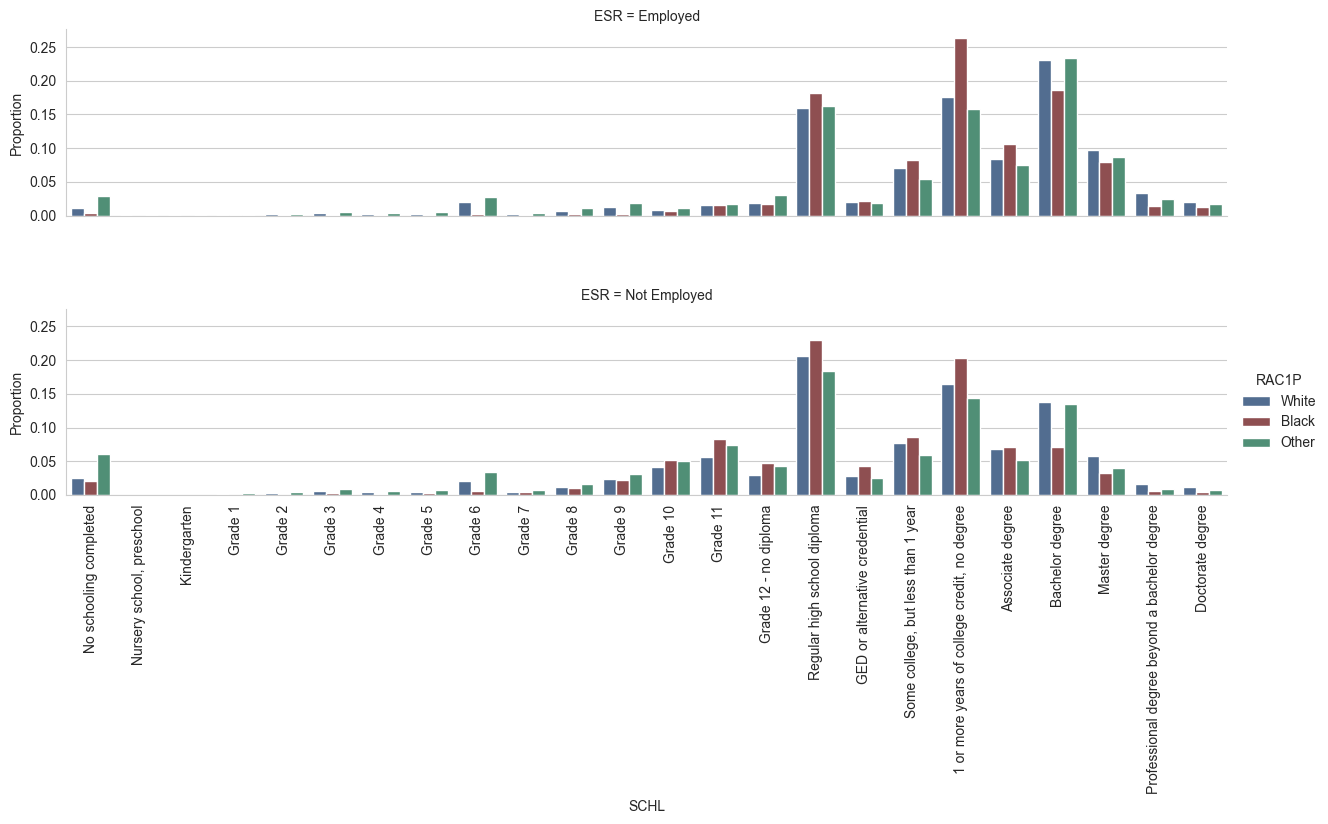

In [8]:
edu_df2 = df1.groupby(by=['YEAR','STATE','SEX','RAC1P','ESR'])['SCHL'].value_counts(normalize=True).to_frame\
    ('Proportion')\
    .reset_index()

g = sns.catplot(data=edu_df2[(edu_df2['YEAR']==2014)&(edu_df2['STATE'].isin(['CA']))],
                x="SCHL",
                y='Proportion',
                hue="RAC1P",
                row='ESR',
                order=[ "No schooling completed","Nursery school, preschool","Kindergarten","Grade 1","Grade 2",
"Grade 3",
"Grade 4",
"Grade 5",
"Grade 6",
"Grade 7",
 "Grade 8",
"Grade 9",
"Grade 10",
"Grade 11",
    "Grade 12 - no diploma",
   "Regular high school diploma",
   "GED or alternative credential",
  "Some college, but less than 1 year",
    "1 or more years of college credit, no degree",
    "Associate degree",
    "Bachelor degree",
"Master degree",
"Professional degree beyond a bachelor degree",
"Doctorate degree"], hue_order=['White','Black','Other'],palette={'White':'#476C9B','Black':'#984447',
                                                                  'Other':'#469978'},
            kind='bar', errorbar=None, aspect=2.5)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.5,hspace=0.5)

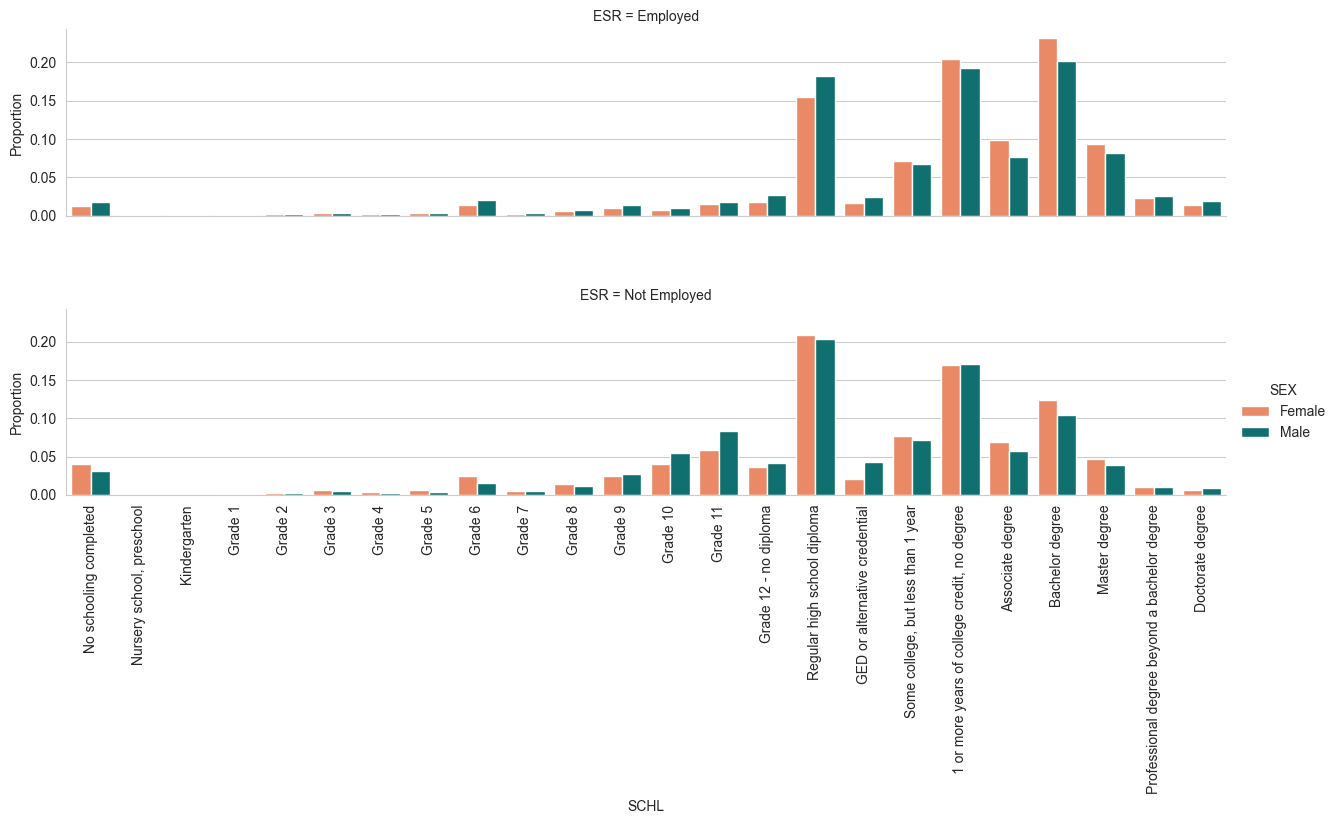

In [10]:
g = sns.catplot(data=edu_df2[(edu_df2['YEAR']==2014)&(edu_df2['STATE'].isin(['CA']))],
                x="SCHL",
                y='Proportion',
                hue="SEX",
                row='ESR',
                order=[ "No schooling completed","Nursery school, preschool","Kindergarten","Grade 1","Grade 2",
"Grade 3",
"Grade 4",
"Grade 5",
"Grade 6",
"Grade 7",
 "Grade 8",
"Grade 9",
"Grade 10",
"Grade 11",
    "Grade 12 - no diploma",
   "Regular high school diploma",
   "GED or alternative credential",
  "Some college, but less than 1 year",
    "1 or more years of college credit, no degree",
    "Associate degree",
    "Bachelor degree",
"Master degree",
"Professional degree beyond a bachelor degree",
"Doctorate degree"], hue_order=['Female','Male'],
                palette={'Female': 'coral', 'Male': 'teal'},
            kind='bar', errorbar=None, aspect=2.5)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.5,hspace=0.5)

## Fairness metrics of original state data for each year (fairlearn metrics)

In [3]:
metricss = []

for y in range(2014,2019):
    data_files = glob.glob(os.path.join(ddir, str(y),'1-Year') + f'\*_ACSEmployment.csv')
    for d in data_files:

        state = os.path.split(d)[1][5:7]
        df = pd.read_csv(d, sep=',', index_col=0)
        df['RAC1P'] = df['RAC1P'].astype(np.int64)
        df.loc[df['RAC1P']>2,'RAC1P'] = 3
        df.set_index(['SEX', 'RAC1P'], inplace=True)

        metricss.append([
            y,
            state,
            statistical_parity_difference(y_true = df['ESR'], prot_attr=['SEX'], priv_group=1, pos_label=1),
            statistical_parity_difference(y_true = df['ESR'], prot_attr=['RAC1P'], priv_group=1, pos_label=1),
            disparate_impact_ratio(y_true = df['ESR'], prot_attr=['SEX'], priv_group=1, pos_label=1),
            disparate_impact_ratio(y_true = df['ESR'], prot_attr=['RAC1P'], priv_group=1, pos_label=1)
        ])


metrics_df = pd.DataFrame(metricss,columns = ['year','state','spd_sex','spd_rac','dir_sex','dir_rac'])
metrics_df


,year,state,spd_sex,spd_rac,dir_sex,dir_rac
0,2014,AK,-0.008412,-0.170292,0.979754,0.654540
1,2014,AL,-0.066095,-0.066345,0.846777,0.840255
2,2014,AR,-0.064887,-0.057076,0.849228,0.859996
3,2014,AZ,-0.055171,-0.068016,0.871084,0.836347
4,2014,CA,-0.073899,-0.015002,0.842165,0.965624
...,...,...,...,...,...,...
245,2018,VT,-0.025879,-0.052604,0.950014,0.896204
246,2018,WA,-0.059067,-0.012614,0.878755,0.972588
247,2018,WI,-0.035345,-0.118356,0.930541,0.764196
248,2018,WV,-0.045285,-0.084910,0.890303,0.784964


In [19]:
metrics_df.to_csv(os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_data","results",'metrics','fairlearn_metrics_ACSEmployment.csv'),
                  sep=',')

In [5]:
fig = px.choropleth(metrics_df[metrics_df['state']!='PR'], locations='state', facet_col='year',
                    facet_col_wrap=1,
                    locationmode="USA-states", color='spd_sex', scope="usa", width=700, height=1800)

fig.show()
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_spd_sex.pdf"))
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_spd_sex.png"))

In [6]:
fig = px.choropleth(metrics_df[metrics_df['state']!='PR'], locations='state', facet_col='year',
                    facet_col_wrap=1,color_continuous_scale="Viridis",
                    locationmode="USA-states", color='spd_rac', scope="usa", width=700, height=1800)

fig.show()
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_spd_rac.pdf"))
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_spd_rac.png"))

In [10]:
fig = px.choropleth(metrics_df[metrics_df['state']!='PR'], locations='state', facet_col='year',
                    facet_col_wrap=1,color_continuous_scale="oranges",
                    locationmode="USA-states", color='dir_sex', scope="usa", width=700, height=1800)

fig.show()
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_dir_sex.pdf"))
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_dir_sex.png"))

In [9]:
fig = px.choropleth(metrics_df[metrics_df['state']!='PR'], locations='state', facet_col='year',
                    facet_col_wrap=1,color_continuous_scale="deep",
                    locationmode="USA-states", color='dir_rac', scope="usa", width=700, height=1800)

fig.show()
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_dir_rac.pdf"))
fig.write_image(os.path.join(fdir, 'ACSEmployment','eda',"metrics_dir_rac.png"))

## Analysis Results

In [52]:
results_dir = r'C:\Users\sarab\Desktop\results_download\ACSEmployment'
years=[2014,2015,2016,2017,2018]
clfiers=["LogReg",'LinearSVC','XGBoost']

states = []
y = []
clf = []
median_sex_dpd = []
median_sex_dpr = []
median_sex_eod = []
median_rac_dpd = []
median_rac_dpr = []
median_rac_edd = []

for year in years:

    # sklearn
    for clfier in clfiers:
        for t in task_infos['states']:
            result_file = glob.glob(os.path.join(results_dir, str(year),'sklearn')+f'/**/spatial_{t}_*_{clfier}.csv',
                                     recursive=True)
            df = pd.read_csv(result_file[0] ,sep=',',header=0)
            y.append(year)
            clf.append(clfier)
            states.append(t)
            median_sex_dpd.append(df['sex_dpd'].median())
            median_sex_dpr.append(df['sex_dpr'].median())
            median_sex_eod.append(df['sex_eod'].median())
            median_rac_dpd.append(df['rac_dpd'].median())
            median_rac_dpr.append(df['rac_dpr'].median())
            median_rac_edd.append(df['rac_edd'].median())

    # aif360
    for t in task_infos['states']:
        result_file = glob.glob(os.path.join(results_dir, str(year),'aif360')+f'/**/spatial_{t}_*_AdversarialDebiasing.csv',
                                 recursive=True)
        if len(result_file)>0:
            df = pd.read_csv(result_file[0] ,sep=',',header=0)
            y.append(year)
            clf.append('AdversarialDebiasing')
            states.append(t)
            median_sex_dpd.append(df['sex_dpd'].median())
            median_sex_dpr.append(df['sex_dpr'].median())
            median_sex_eod.append(df['sex_eod'].median())
            median_rac_dpd.append(df['rac_dpd'].median())
            median_rac_dpr.append(df['rac_dpr'].median())
            median_rac_edd.append(df['rac_edd'].median())


final=pd.DataFrame(zip(y,states,clf, median_sex_dpd,
                        median_sex_dpr,
                        median_sex_eod,
                        median_rac_dpd,
                        median_rac_dpr,
                        median_rac_edd),
                   columns=['year','state','classifier',
                            'median_sex_dpd',
                        'median_sex_dpr',
                        'median_sex_eod',
                        'median_rac_dpd',
                        'median_rac_dpr',
                        'median_rac_edd'])

final

,year,state,classifier,median_sex_dpd,median_sex_dpr,median_sex_eod,median_rac_dpd,median_rac_dpr,median_rac_edd
0,2014,AL,LogReg,0.001058,0.888040,0.002618,0.015934,0.248490,0.022466
1,2014,AK,LogReg,0.011674,0.507687,0.016083,0.112534,0.012916,0.124263
2,2014,AZ,LogReg,0.000195,0.714100,0.000456,0.000767,0.000000,0.001314
3,2014,AR,LogReg,0.000563,0.898586,0.001563,0.005028,0.522488,0.008400
4,2014,CA,LogReg,0.000059,0.579906,0.000146,0.000322,0.000000,0.000616
...,...,...,...,...,...,...,...,...,...
946,2018,OR,AdversarialDebiasing,0.016423,0.948233,0.023772,0.167289,0.635218,0.253306
947,2018,PA,AdversarialDebiasing,0.049774,0.849206,0.058361,0.226887,0.544679,0.305257
948,2018,RI,AdversarialDebiasing,0.079931,0.816787,0.089816,0.168795,0.688607,0.200308
949,2018,SC,AdversarialDebiasing,0.019706,0.938587,0.024556,0.093304,0.760739,0.123433


C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis\venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.

C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis\venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



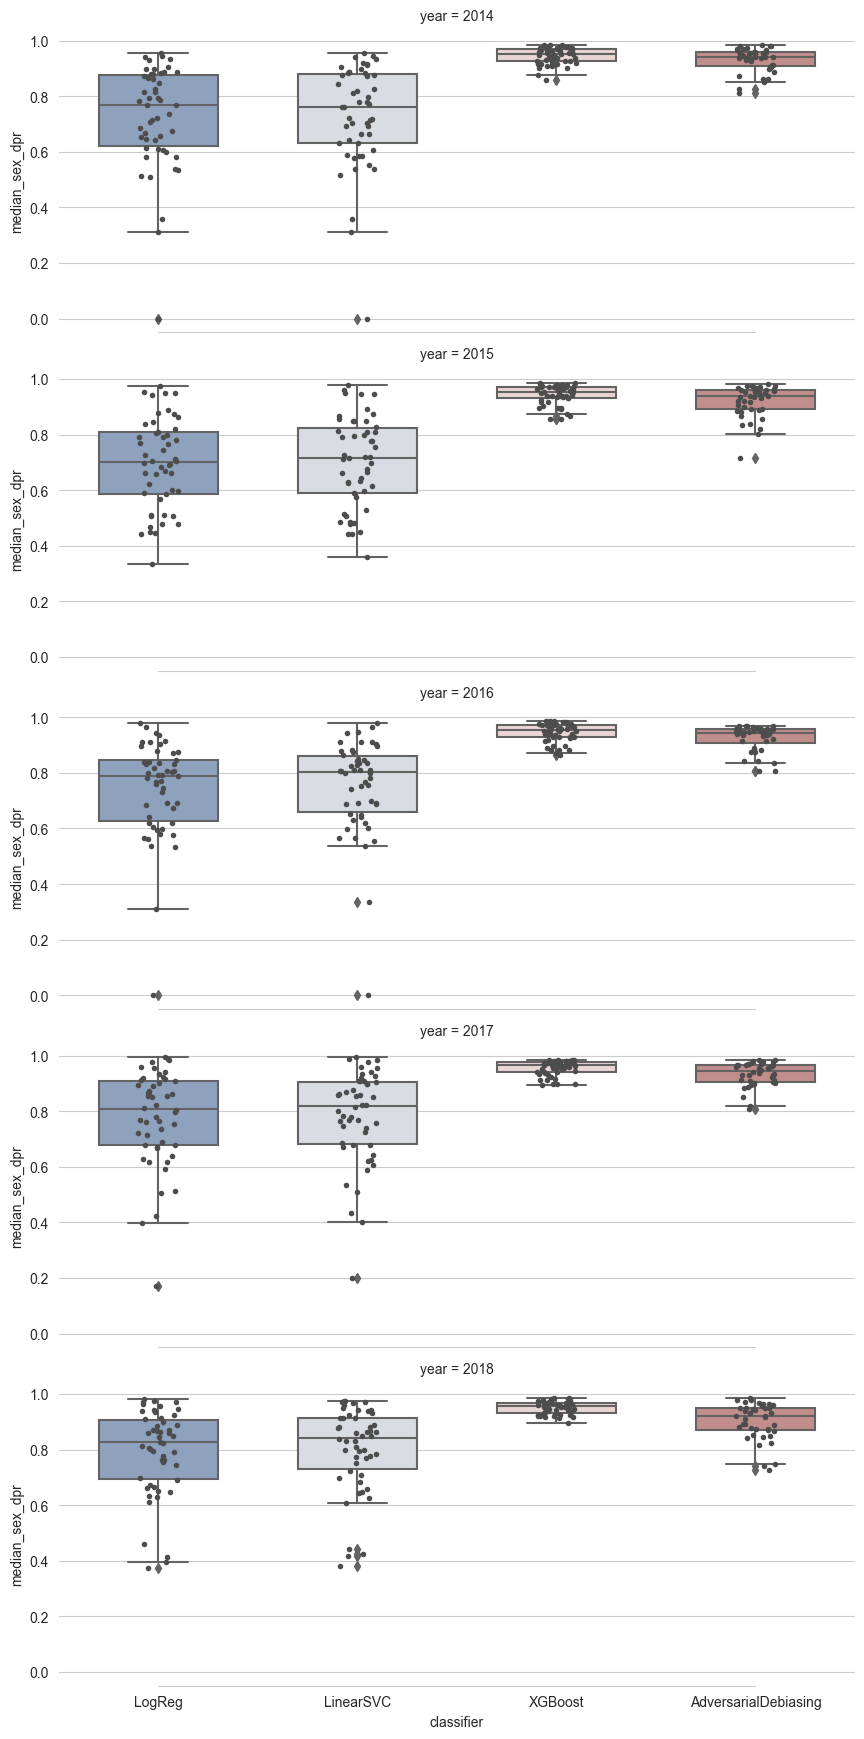

In [53]:
g = sns.FacetGrid(final, row="year",height=3.5, aspect=2.5)
g.map(sns.boxplot,"classifier", "median_sex_dpr", width=.6, palette="vlag")
g.map(sns.stripplot,"classifier", "median_sex_dpr", size=4, color=".3", linewidth=0)

# f, ax = plt.subplots(figsize=(7, 6))
# # Plot the orbital period with horizontal boxes
# sns.boxplot(y="median_sex_dpr", x="classifier", data=final, width=.6, palette="vlag")
#
# # Add in points to show each observation
# sns.stripplot(y="median_sex_dpr", x="classifier", data=final,
#               size=4, color=".3", linewidth=0)
#
# # Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.set(ylabel="")
sns.despine(trim=True, left=True)


C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis\venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.

C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis\venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



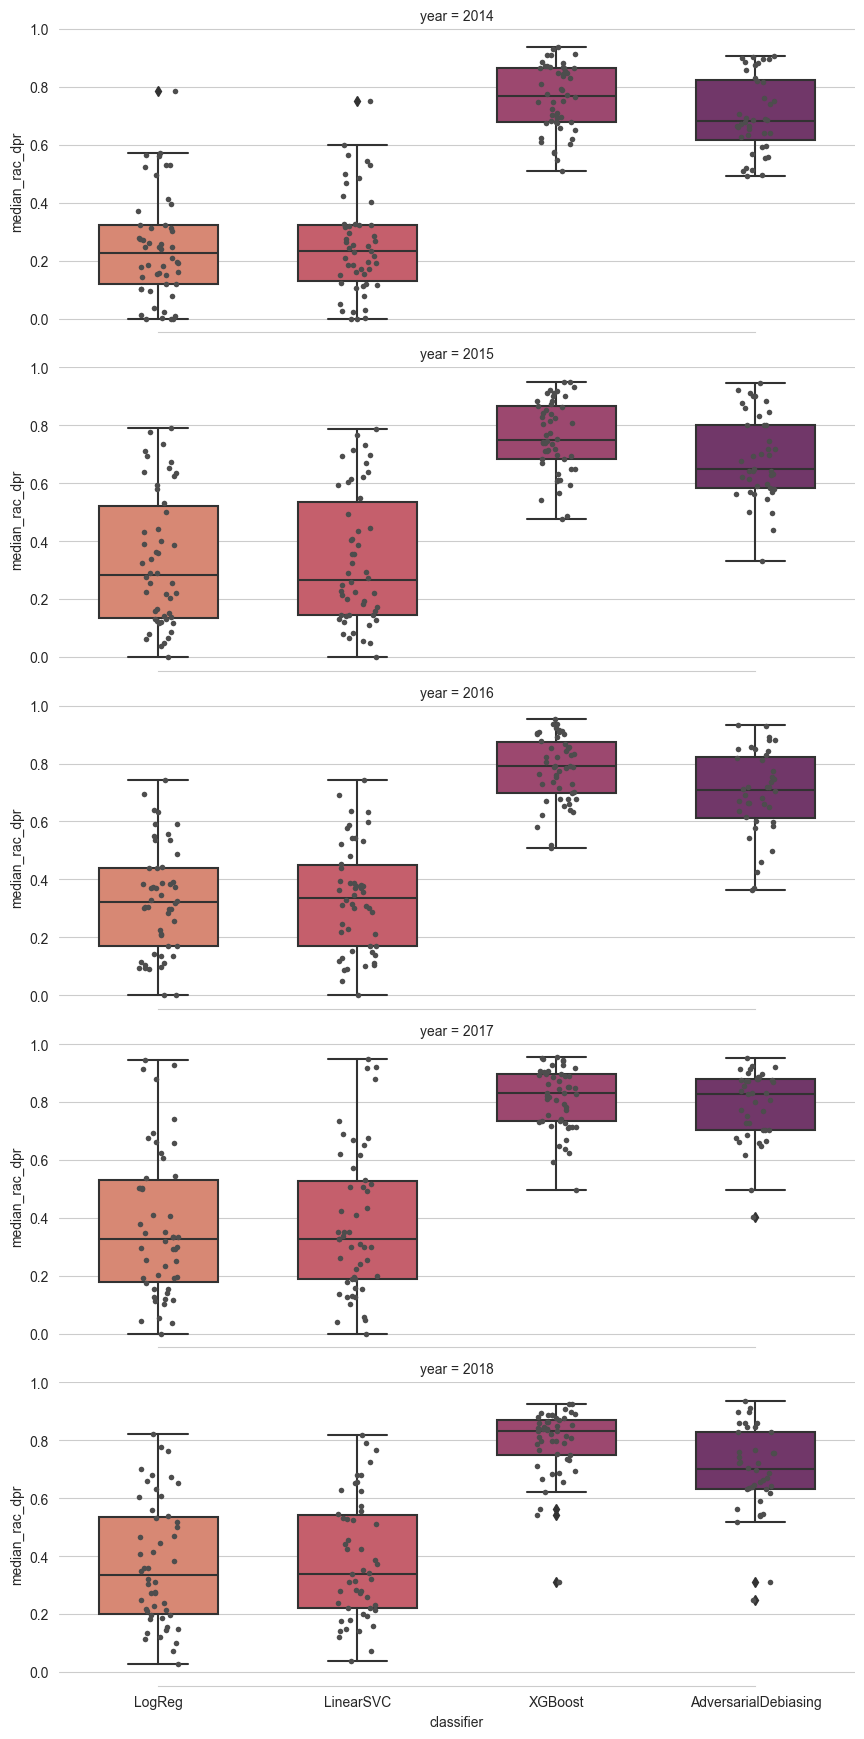

In [55]:
g = sns.FacetGrid(final, row="year",height=3.5, aspect=2.5)
g.map(sns.boxplot,"classifier", "median_rac_dpr", width=.6, palette="flare")
g.map(sns.stripplot,"classifier", "median_rac_dpr", size=4, color=".3", linewidth=0)

sns.despine(trim=True, left=True)

C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis\venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.

C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis\venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



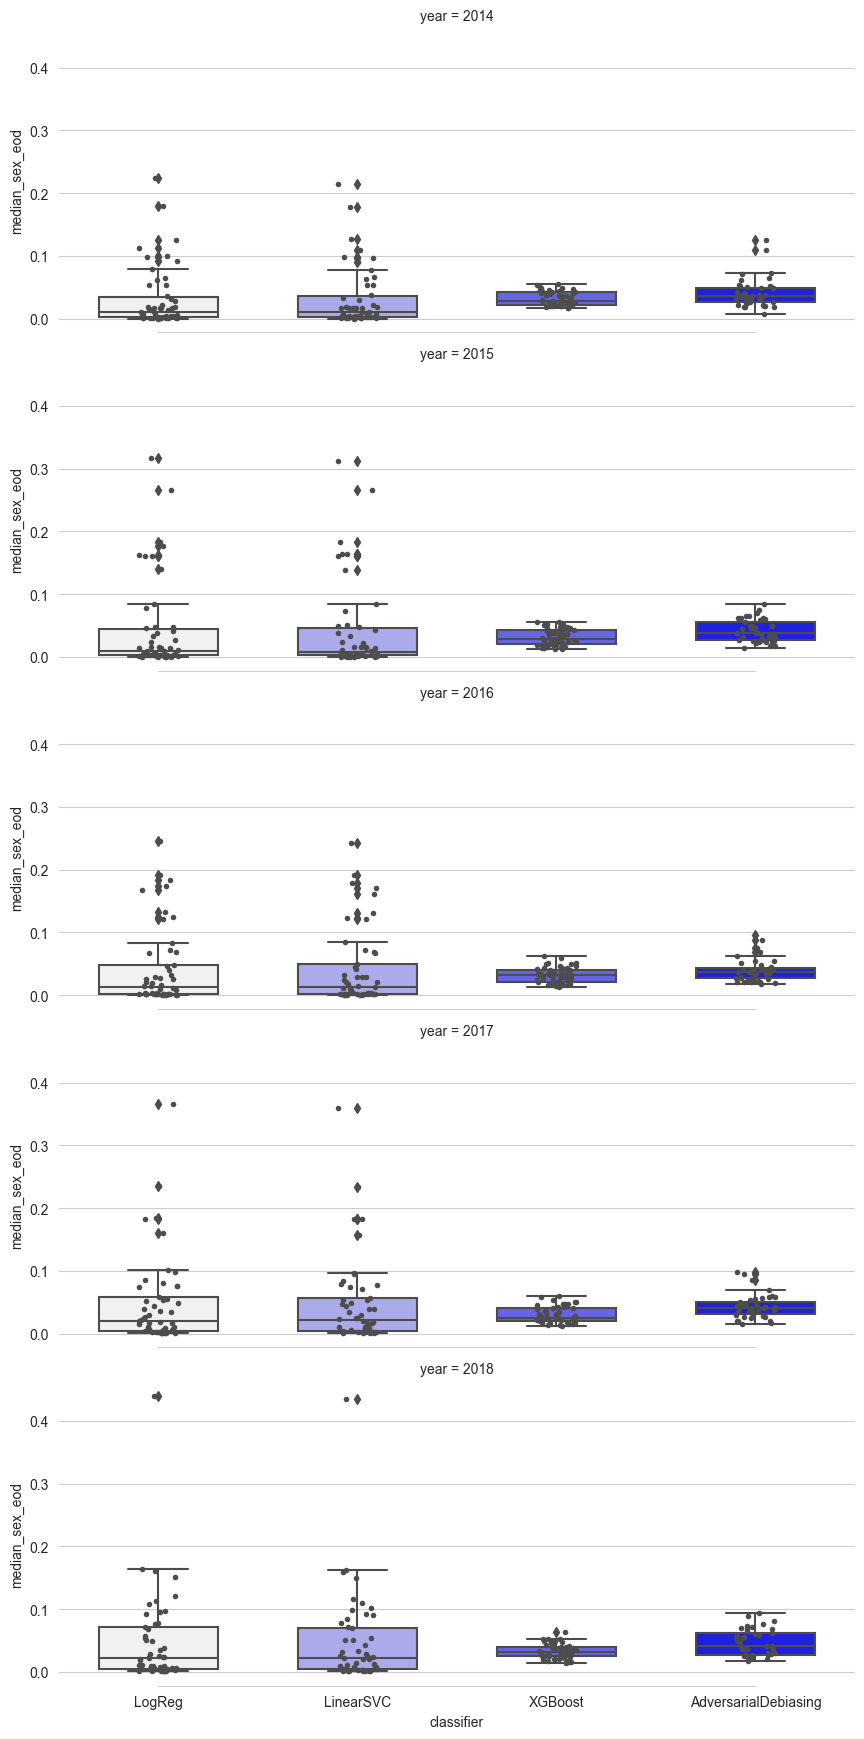

In [56]:
g = sns.FacetGrid(final, row="year",height=3.5, aspect=2.5)
g.map(sns.boxplot,"classifier", "median_sex_eod", width=.6, palette="light:b")
g.map(sns.stripplot,"classifier", "median_sex_eod", size=4, color=".3", linewidth=0)

sns.despine(trim=True, left=True)

C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis\venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.

C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis\venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



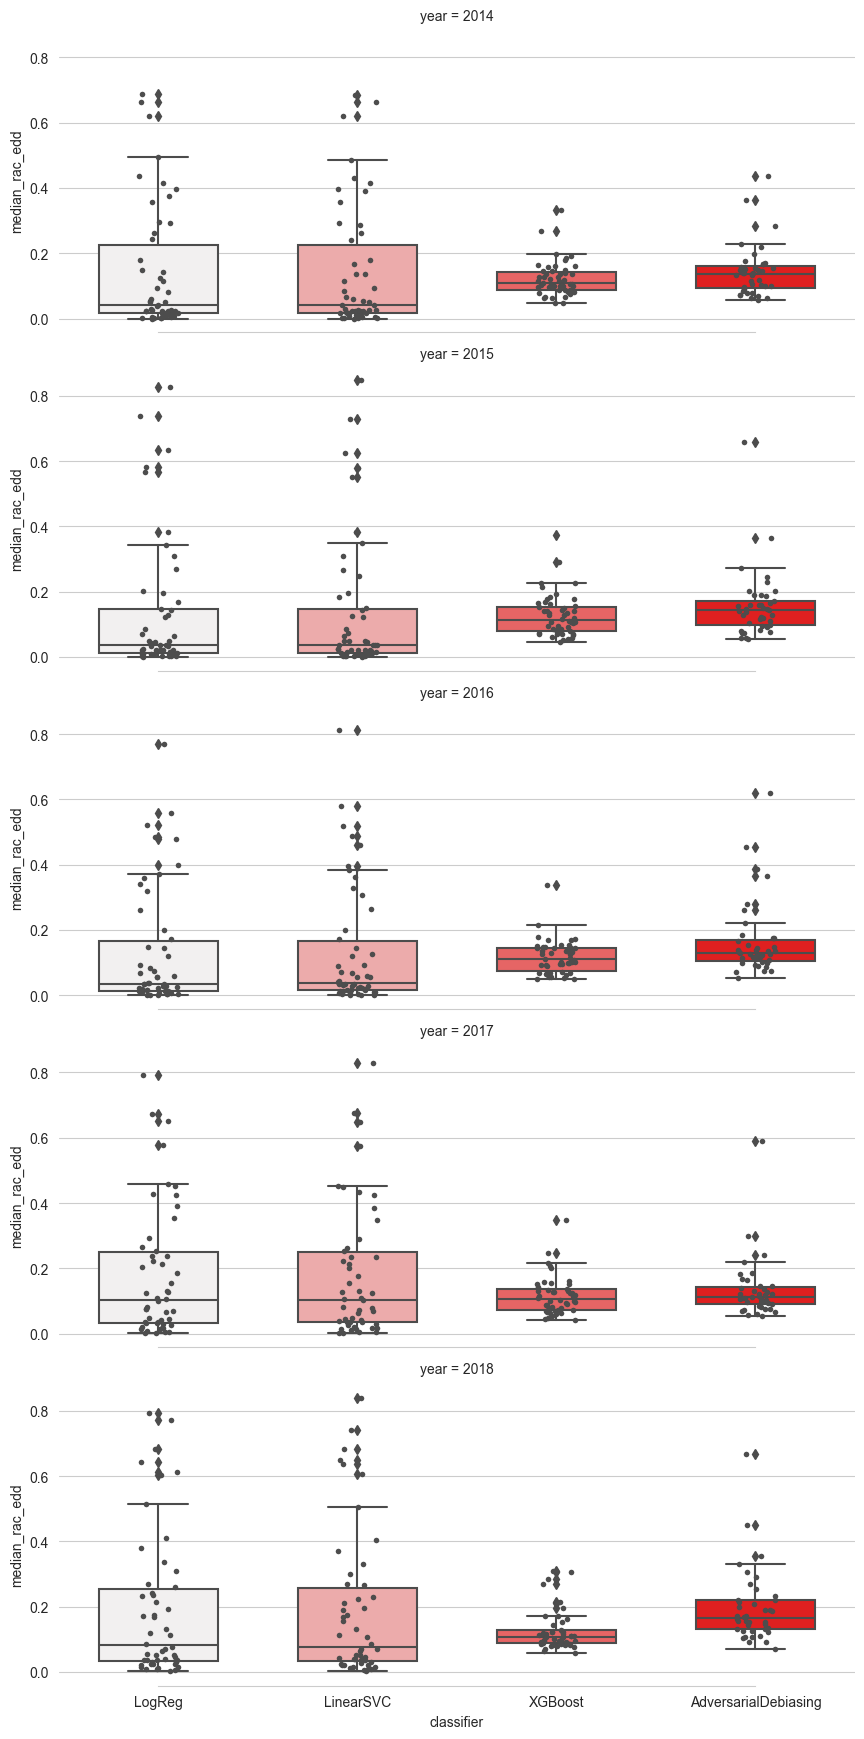

In [57]:
g = sns.FacetGrid(final, row="year",height=3.5, aspect=2.5)
g.map(sns.boxplot,"classifier", "median_rac_edd", width=.6, palette="light:r")
g.map(sns.stripplot,"classifier", "median_rac_edd", size=4, color=".3", linewidth=0)

sns.despine(trim=True, left=True)

## Temporal plots

In [12]:
results_dir = r'C:\Users\sarab\Desktop\results_download\ACSEmployment'
clfiers=["LogReg",'LinearSVC','XGBoost']

dfs = []


for t in task_infos['states']:
    result_file = glob.glob(os.path.join(results_dir, '2014','sklearn')+f'/**/temporal_{t}_*_2014.csv',
                             recursive=True)
    df = pd.read_csv(result_file[0] ,sep=',',header=0)
    df.rename(columns={'Unnamed: 0':'classifier',
                       'Unnamed: 1':'year'}, inplace=True )
    df['train_state'] = t
    dfs.append(df)

# aif360
for t in task_infos['states']:
    result_file = glob.glob(os.path.join(results_dir, '2014','aif360')+f'/**/temporal_{t}_*_2014.csv',recursive=True)
    if len(result_file)>0:
        df = pd.read_csv(result_file[0] ,sep=',',header=0)
        df.rename(columns={'Unnamed: 0':'classifier',
                   'Unnamed: 1':'year'}, inplace=True )

        df['train_state'] = t
        dfs.append(df)

final_temporal = pd.concat(dfs, axis=0)
final_temporal

,classifier,year,train_kfold_accuracy,accuracy,bal_accuracy,precision,recall,sex_dpd,sex_dpr,sex_eod,rac_dpd,rac_dpr,rac_edd,train_state
0,LinearSVC,2015,0.603397,0.512748,0.496356,0.267477,0.004665,0.003534,0.656335,0.006791,0.016845,0.298641,0.020248,AL
1,LinearSVC,2016,0.603397,0.505029,0.497307,0.320261,0.005096,0.002045,0.770422,0.003787,0.019595,0.258583,0.029820,AL
2,LinearSVC,2017,0.603397,0.507573,0.497473,0.318339,0.004790,0.001600,0.805097,0.002351,0.022259,0.203461,0.027676,AL
3,LinearSVC,2018,0.603397,0.501727,0.498879,0.428125,0.007001,0.001890,0.792720,0.002713,0.017987,0.280032,0.019234,AL
4,LogReg,2015,0.603448,0.513004,0.496599,0.271565,0.004506,0.003391,0.653853,0.006312,0.014941,0.315685,0.019116,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,AdversarialDebiasing,2018,0.497568,0.465807,0.473344,0.592035,0.441741,0.073800,0.851976,0.094450,0.136685,0.770960,0.227642,SD
0,AdversarialDebiasing,2015,0.547790,0.453311,0.471693,0.458377,0.169231,0.020050,0.902796,0.040052,0.146424,0.551671,0.175832,TN
1,AdversarialDebiasing,2016,0.547790,0.453702,0.472646,0.462869,0.172651,0.012330,0.939752,0.029951,0.147831,0.550941,0.155797,TN
2,AdversarialDebiasing,2017,0.547790,0.449093,0.473073,0.474607,0.177875,0.008346,0.959668,0.033941,0.148041,0.556678,0.179869,TN


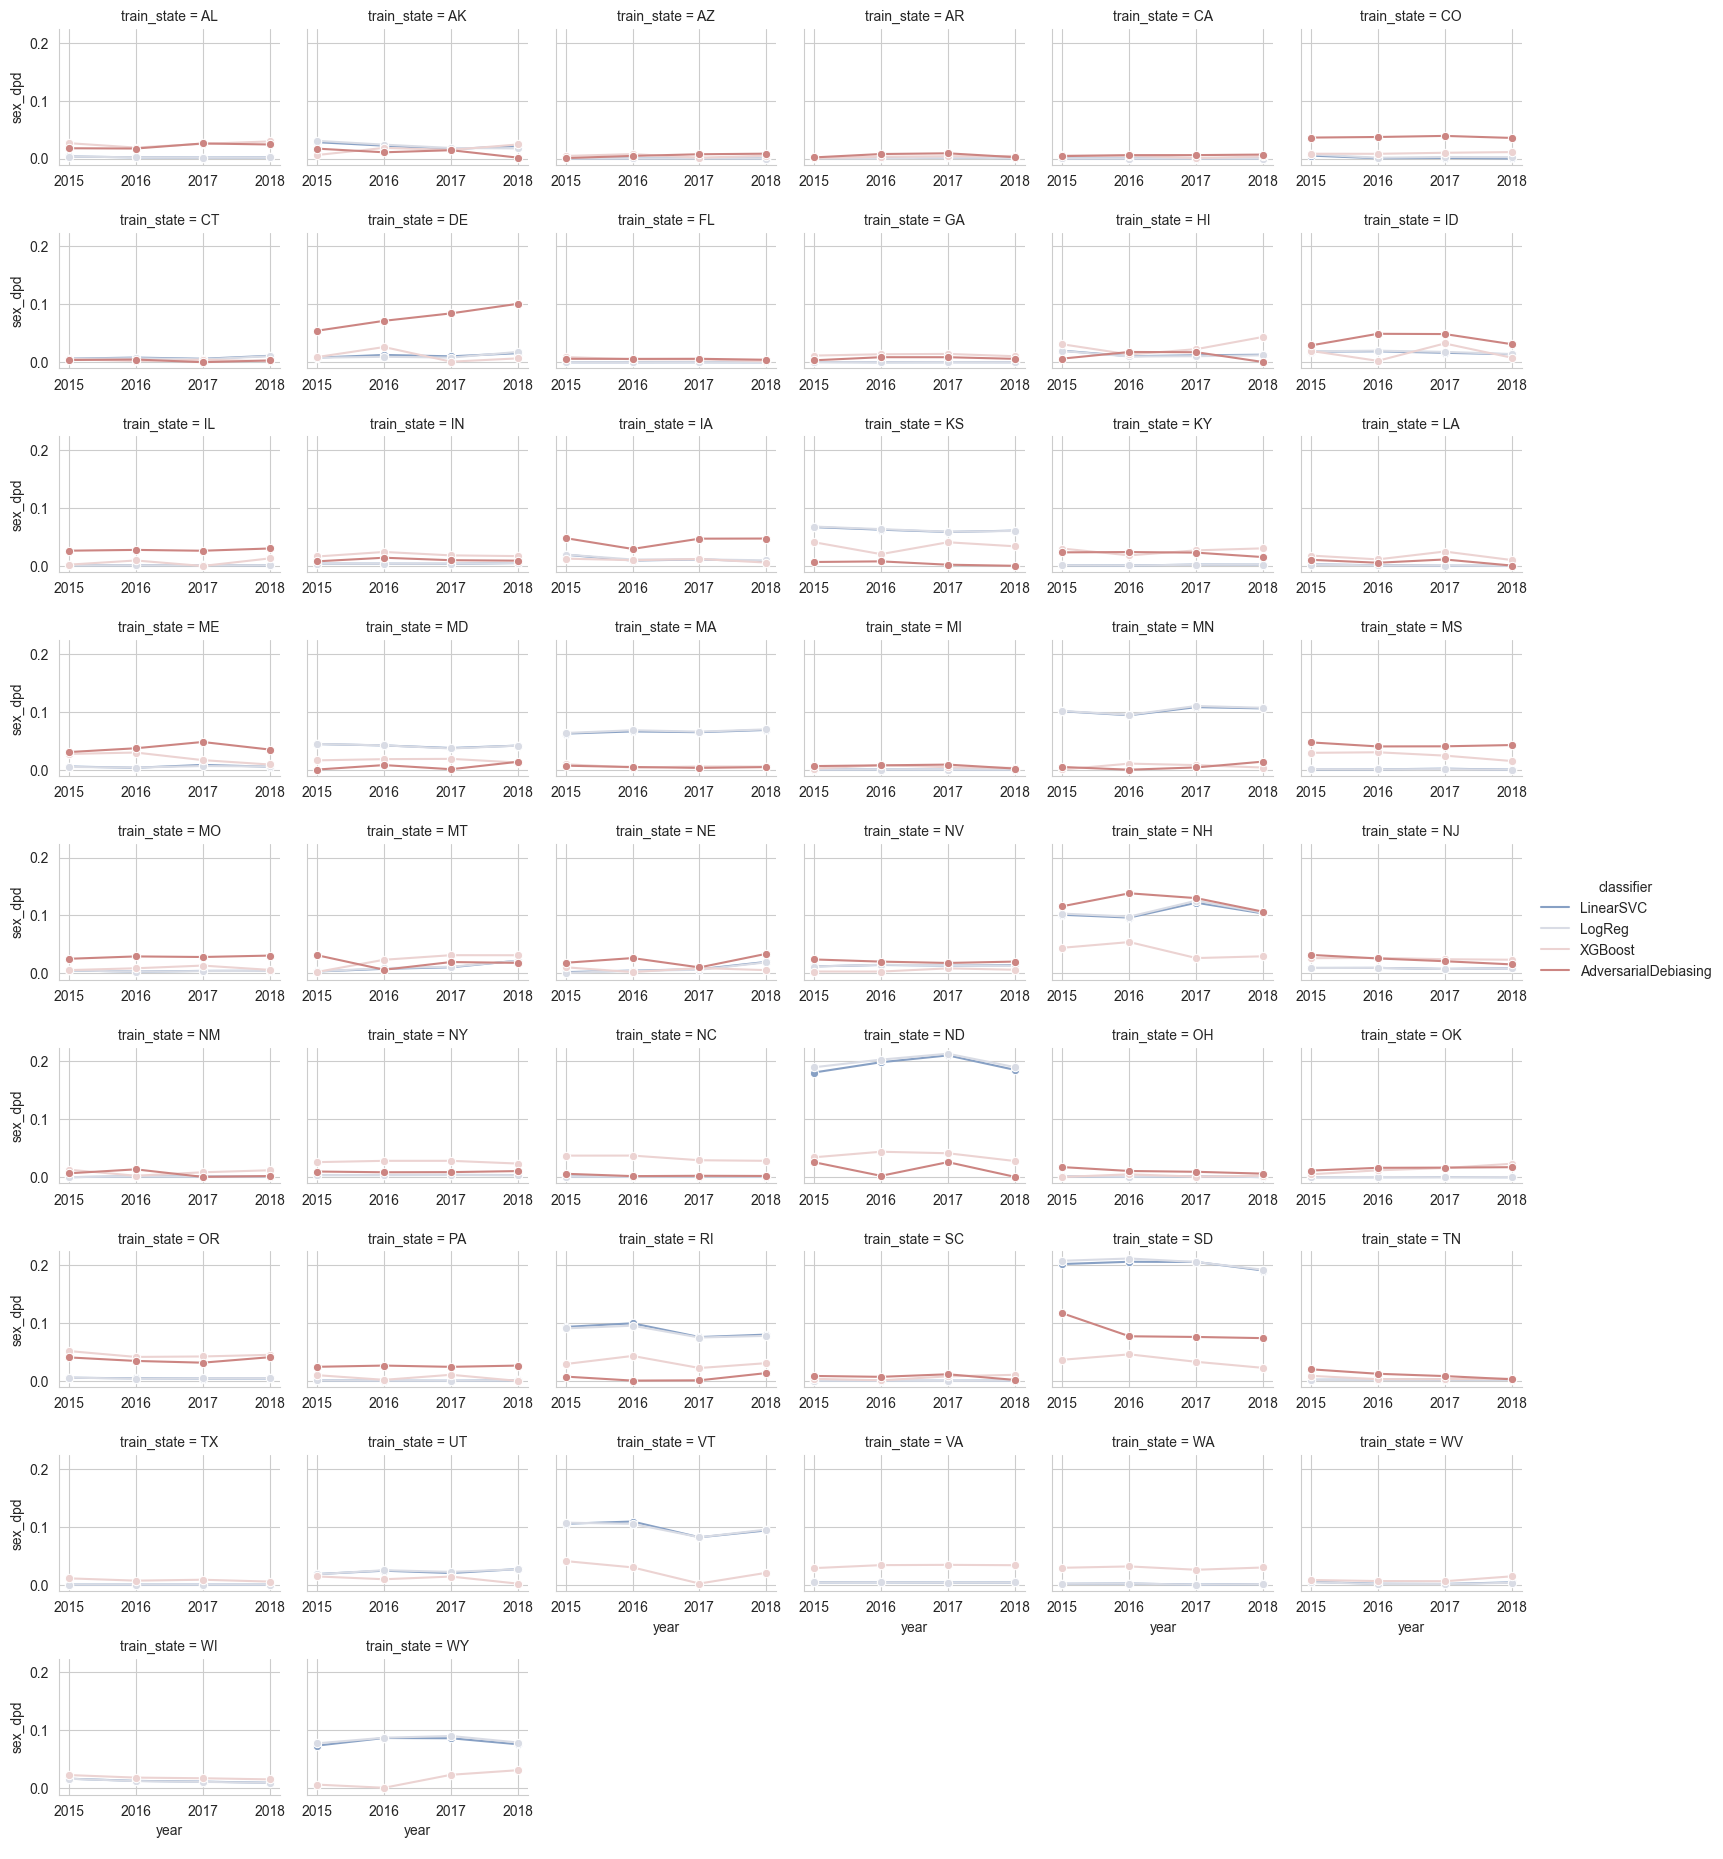

In [34]:
g = sns.relplot(data=final_temporal, kind='line',x="year",y="sex_dpd", marker='o',
                hue="classifier", col="train_state",col_wrap=6, palette='vlag',
                height=4, aspect=0.65
           )
for ax in g.axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("year")
    plt.subplots_adjust(bottom=0.5,hspace=0.5)

task='ACSEmployment'
plt.savefig(os.path.join(fdir,task,'results',f'temporal_sex_dpd.png'),format='png',dpi=300)

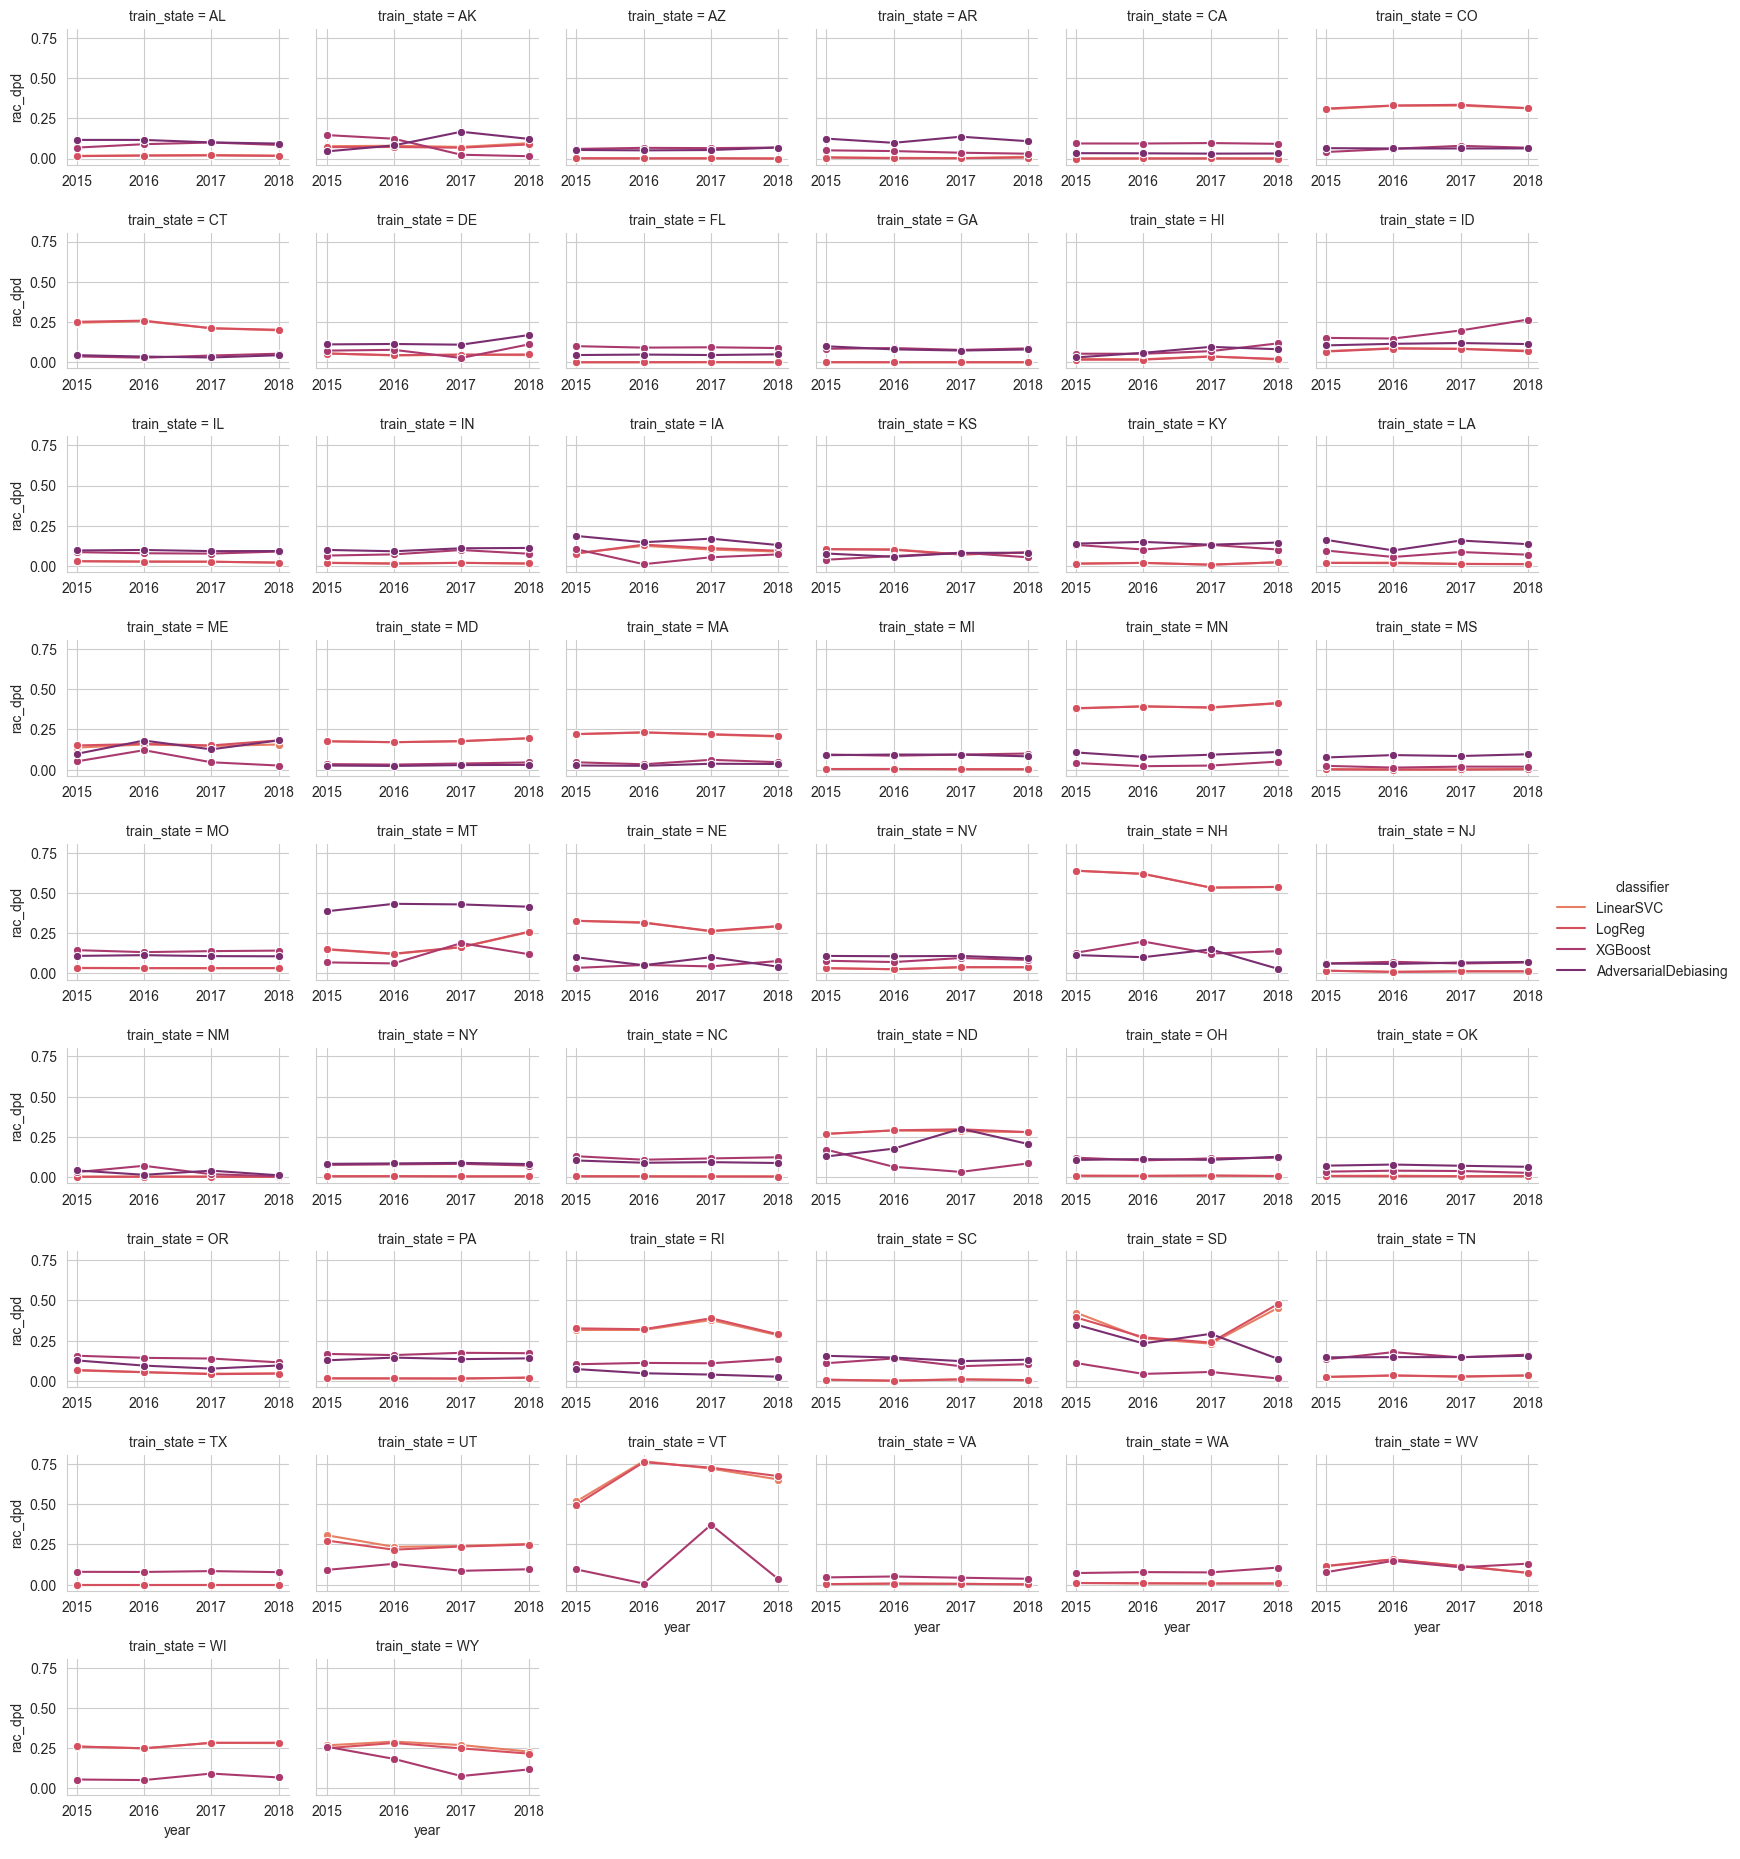

In [31]:
g = sns.relplot(data=final_temporal, kind='line',x="year",y="rac_dpd", marker='o',
                hue="classifier", col="train_state",col_wrap=6, palette='flare',
                height=4, aspect=0.65
           )
for ax in g.axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("year")
    plt.subplots_adjust(bottom=0.5,hspace=0.5)
plt.savefig(os.path.join(fdir,task,'results',f'temporal_rac_dpd.png'),format='png',dpi=300)

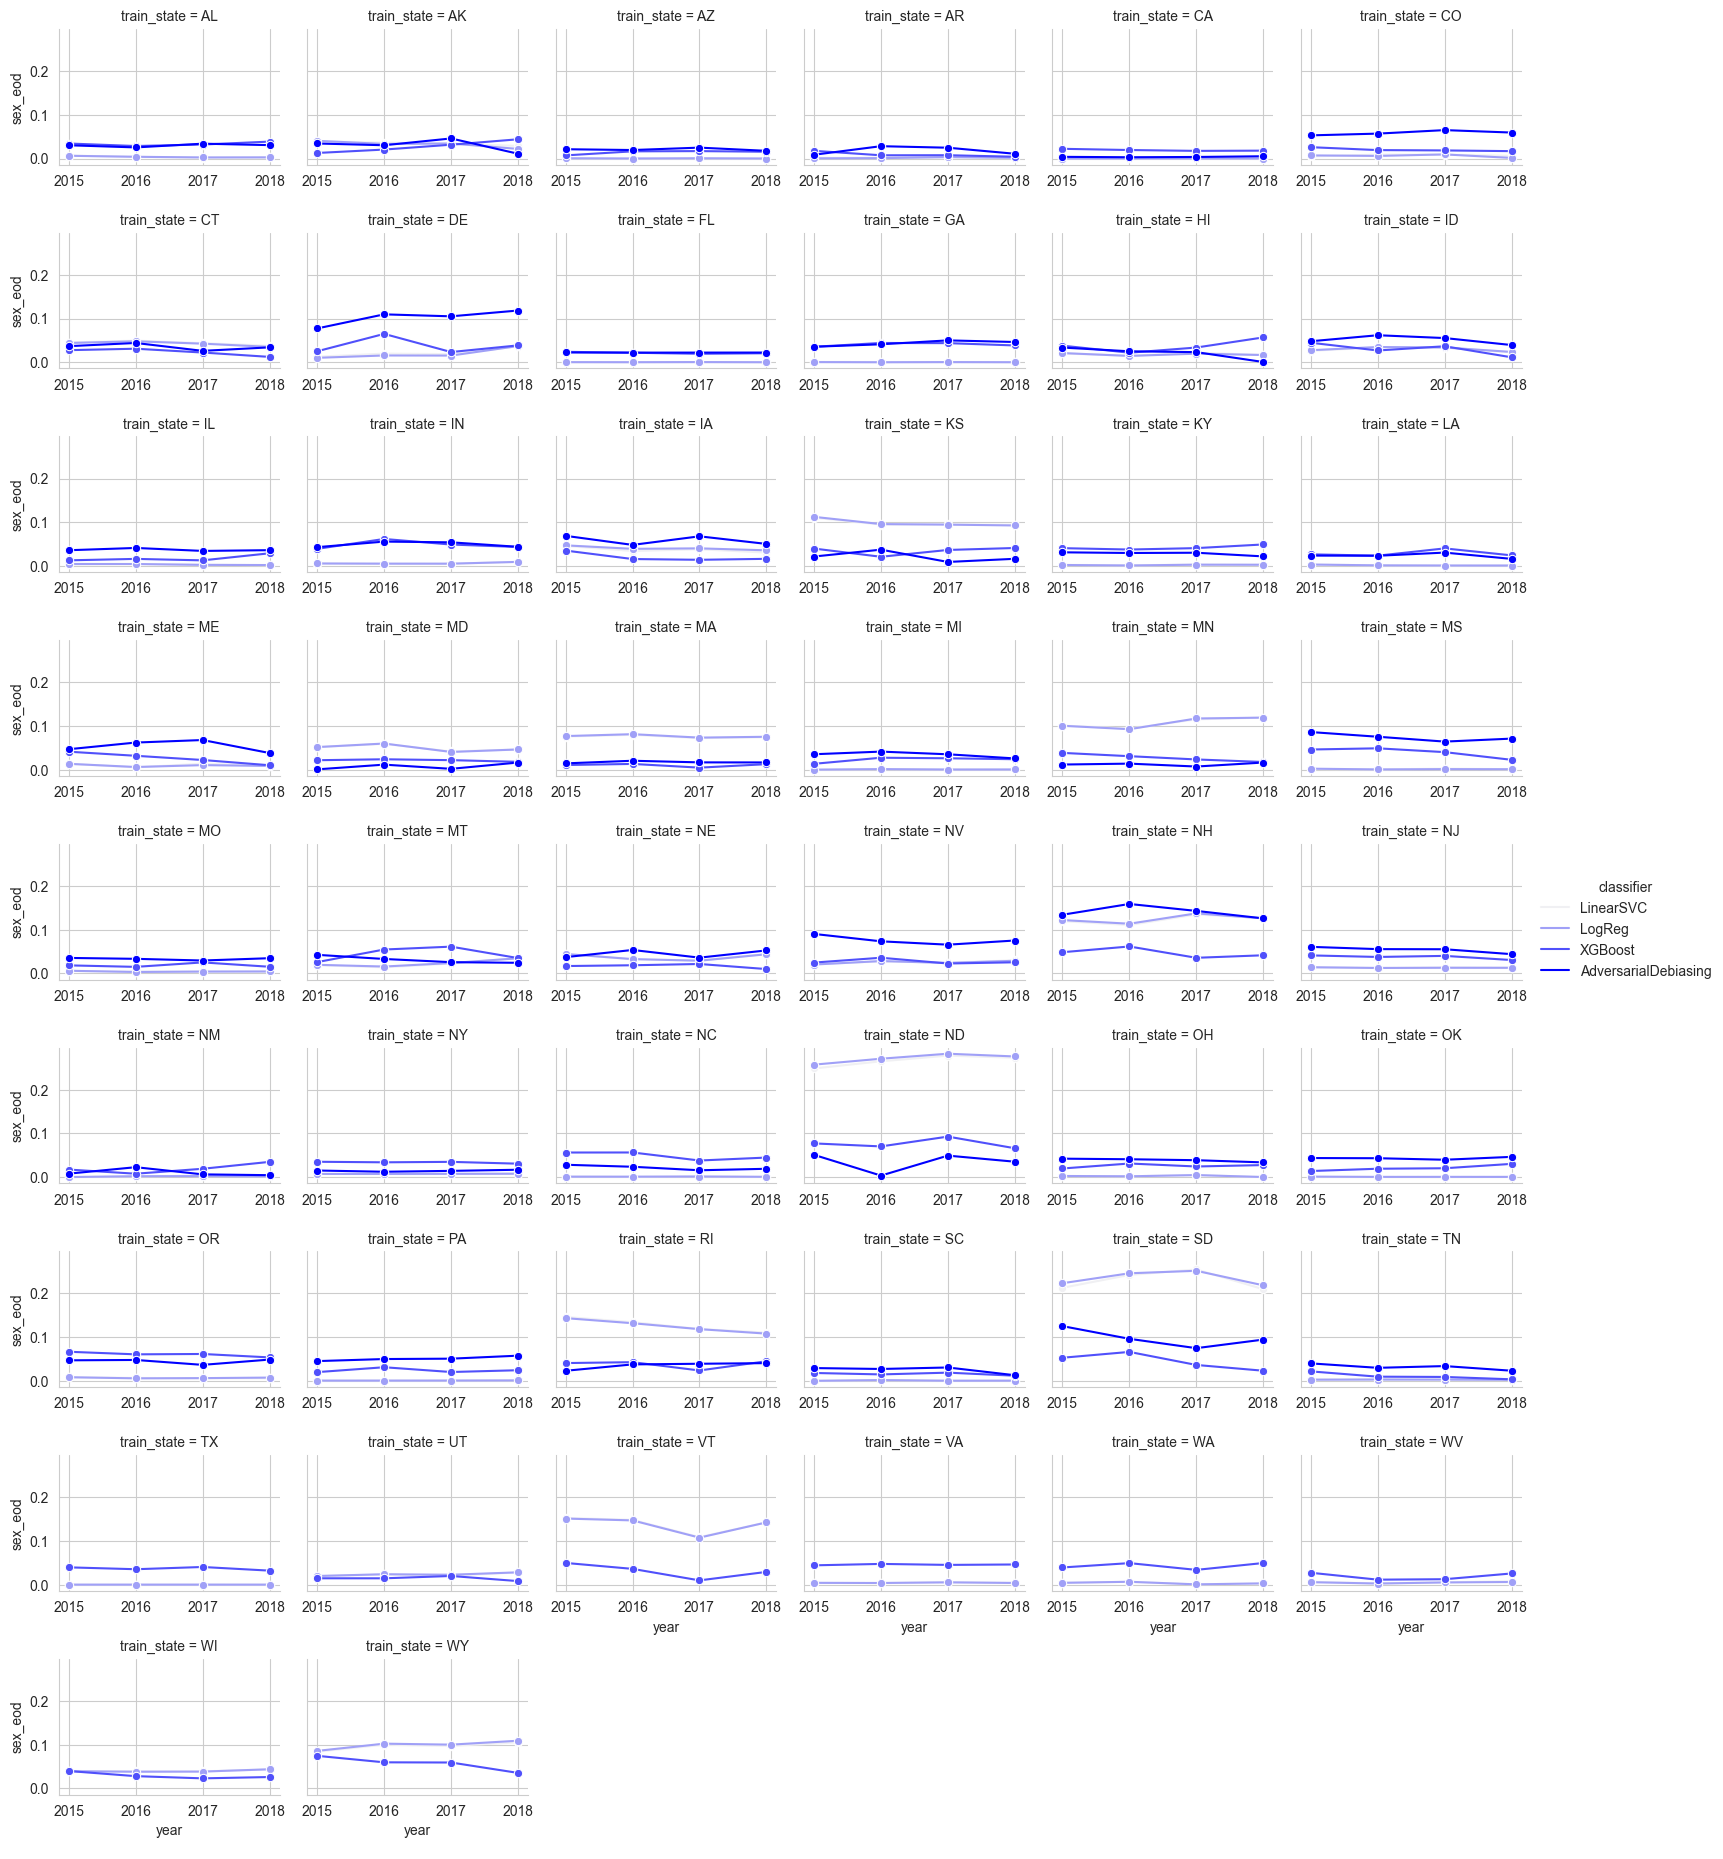

In [32]:
g = sns.relplot(data=final_temporal, kind='line',x="year",y="sex_eod", marker='o',
                hue="classifier", col="train_state",col_wrap=6, palette='light:b',
                height=4, aspect=0.65
           )
for ax in g.axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("year")
    plt.subplots_adjust(bottom=0.5,hspace=0.5)
plt.savefig(os.path.join(fdir,task,'results',f'temporal_sex_eod.png'),format='png',dpi=300)

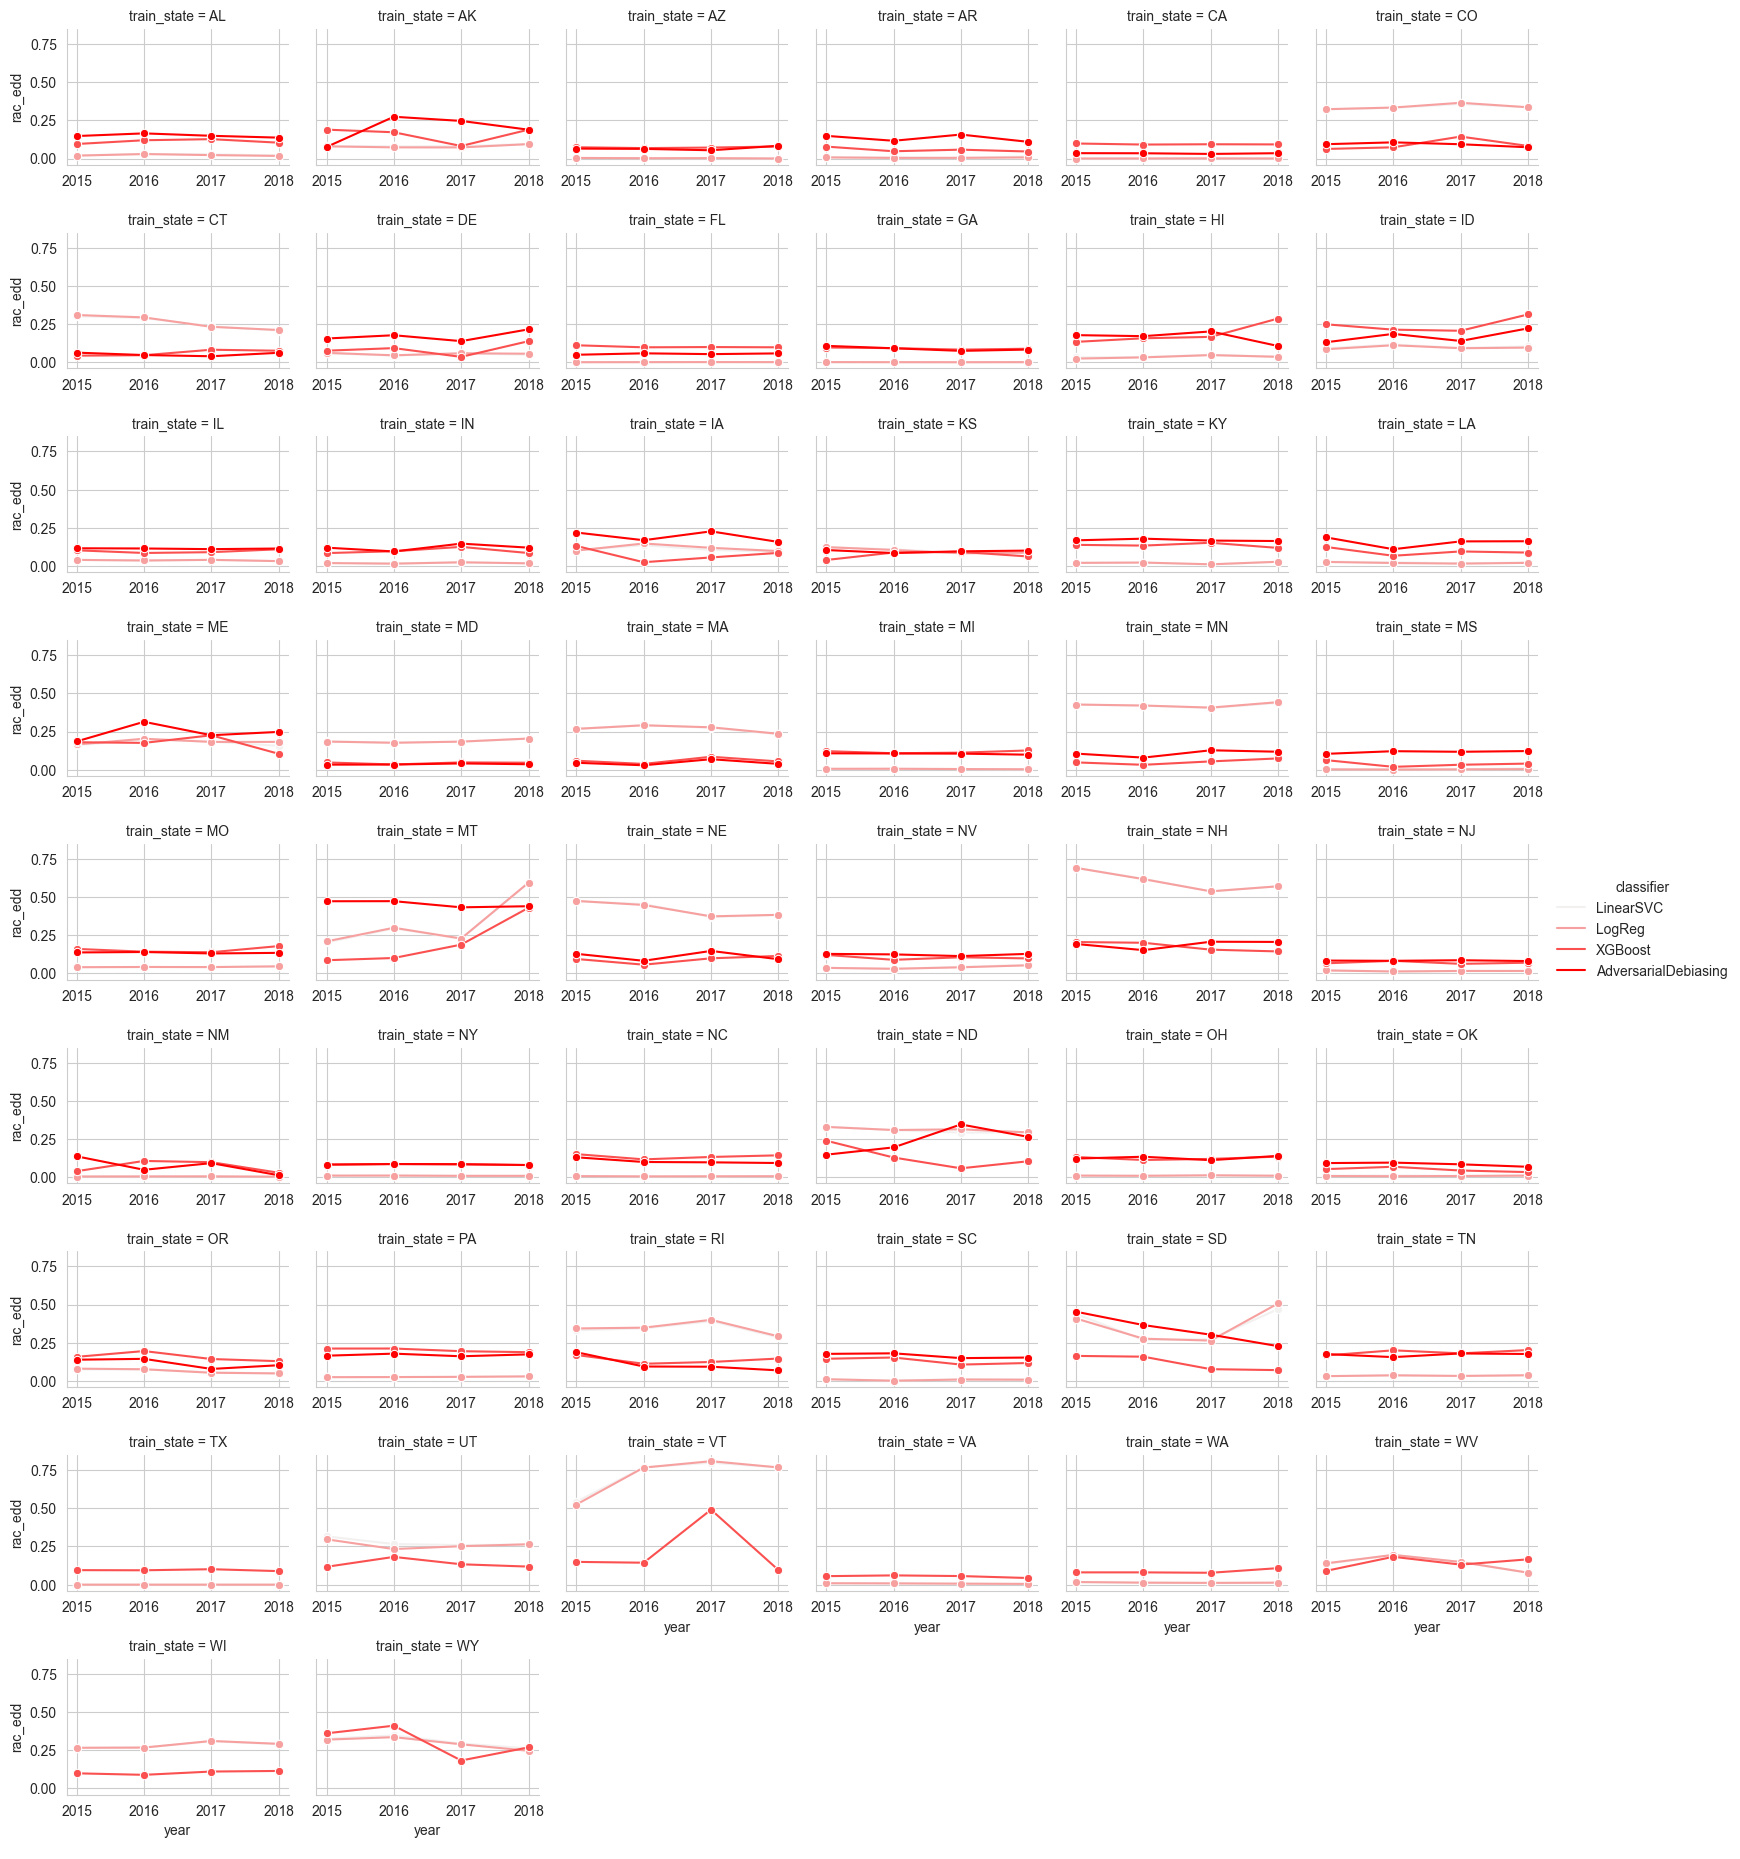

In [33]:
g = sns.relplot(data=final_temporal, kind='line',x="year",y="rac_edd", marker='o',
                hue="classifier", col="train_state",col_wrap=6, palette='light:r',
                height=4, aspect=0.65
           )
for ax in g.axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("year")
    plt.subplots_adjust(bottom=0.5,hspace=0.5)
plt.savefig(os.path.join(fdir,task,'results',f'temporal_rac_edd.png'),format='png',dpi=300)

### ROC curves

In [8]:
protected_variables = {'SEX':['male','female'], 'RAC1P':['white','black','other']}
classifier_name = "LogReg"

# ----Protected attribute: SEX---
# collect all pickle files
state_spatial_path = os.path.join(os.path.split(ddir)[0],'results','ACSEmployment','2014','sklearn','CA')
pickle_files = glob.glob(state_spatial_path + f'\*_{classifier_name}.pickle')

In [21]:


fpr_mean = np.linspace(0, 1, 100)
interp_tprs = {i: np.zeros((len(pickle_files),100)) for i in protected_variables['SEX']}
for i in range(len(pickle_files)):
    file = open(pickle_files[i], 'rb')
    data = pickle.load(file)

    fpr_male = data['SEX_fpr']['male']
    tpr_male = data['SEX_tpr']['male']
    fpr_female = data['SEX_fpr']['female']
    tpr_female = data['SEX_tpr']['female']

    interp_tpr_male = np.interp(fpr_mean, fpr_male, tpr_male)
    interp_tpr_male[0] = 0.0
    interp_tprs['male'][i,:]= interp_tpr_male
    interp_tpr_female = np.interp(fpr_mean, fpr_female, tpr_female)
    interp_tpr_female[0] = 0.0
    interp_tprs['female'][i,:]= interp_tpr_female

tpr_mean_male = np.mean(interp_tprs['male'], axis=0)
tpr_mean_male[-1] = 1.0
tpr_std_male = 2 * np.std(interp_tprs['male'], axis=0)
tpr_upper_male = np.clip(tpr_mean_male + tpr_std_male, 0, 1)
tpr_lower_male = tpr_mean_male - tpr_std_male

tpr_mean_female = np.mean(interp_tprs['female'], axis=0)
tpr_mean_female[-1] = 1.0
tpr_std_female = 2 * np.std(interp_tprs['female'], axis=0)
tpr_upper_female = np.clip(tpr_mean_female + tpr_std_female, 0, 1)
tpr_lower_female = tpr_mean_female - tpr_std_female

# sex variable figure
fig = go.Figure([
    go.Scatter(
        x=fpr_mean,
        y=tpr_upper_male,
        line=dict(color='blue', width=1),
        hoverinfo="skip",
        showlegend=False,
        name='upper'),
    go.Scatter(
        x=fpr_mean,
        y=tpr_lower_male,
        fill='tonexty',
        fillcolor="rgb(166,206,227)",
        line=dict(color='blue', width=1),
        hoverinfo="skip",
        showlegend=False,
        name='lower'),
    go.Scatter(
        x=fpr_mean,
        y=tpr_mean_male,
        line=dict(color='blue', width=2),
        hoverinfo="skip",
        showlegend=True,
        name=f'AUC: '),

    go.Scatter(
        x=fpr_mean,
        y=tpr_upper_female,
        line=dict(color='red', width=1),
        hoverinfo="skip",
        showlegend=False,
        name='upper'),
    go.Scatter(
        x=fpr_mean,
        y=tpr_lower_female,
        fill='tonexty',
        fillcolor="rgb(251,154,153)",
        line=dict(color='red', width=1),
        hoverinfo="skip",
        showlegend=False,
        name='lower'),
    go.Scatter(
        x=fpr_mean,
        y=tpr_mean_female,
        line=dict(color='red', width=2),
        hoverinfo="skip",
        showlegend=True,
        name=f'AUC: ')
])
fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template='plotly_white',
    title_x=0.5,
    xaxis_title="False positive rate (FPR)",
    yaxis_title="True positive rate (TPR)",
    width=800,
    height=800,
    legend=dict(
        yanchor="bottom",
        xanchor="right",
        x=0.95,
        y=0.01,
    )
)
fig.update_yaxes(
    range=[0, 1],
    gridcolor='gray',
    scaleanchor="x",
    scaleratio=1,
    linecolor='black')
fig.update_xaxes(
    range=[0, 1],
    gridcolor='gray',
    constrain='domain',
    linecolor='black')


In [ ]:
# ----Protected attribute: RAC1P---
# collect all pickle files
state_spatial_paths = []
pickle_files = glob.glob(state_spatial_paths + r'\*.pickle')

fpr_mean = np.linspace(0, 1, 100)
interp_tprs = {i: [] for i in protected_variables['RAC1P']}
for i in range(len(pickle_files)):
    file = open(pickle_files[i], 'rb')
    data = pickle.load(file)

    fpr_white = data['RAC1P_fpr']['white']
    tpr_white = data['RAC1P_tpr']['white']
    interp_tpr_white = np.interp(fpr_mean, fpr_white, tpr_white)
    interp_tpr_white[0] = 0.0
    interp_tprs['white'].append(interp_tpr_white)

tpr_mean = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std = 2 * np.std(interp_tprs, axis=0)
tpr_upper = np.clip(tpr_mean + tpr_std, 0, 1)
tpr_lower = tpr_mean - tpr_std

# sex variable figure
fig = go.Figure([
    go.Scatter(
        x=fpr_mean,
        y=tpr_upper,
        line=dict(color='blue', width=1),
        hoverinfo="skip",
        showlegend=False,
        name='upper'),
    go.Scatter(
        x=fpr_mean,
        y=tpr_lower,
        fill='tonexty',
        fillcolor='red',
        line=dict(color='blue', width=1),
        hoverinfo="skip",
        showlegend=False,
        name='lower'),
    go.Scatter(
        x=fpr_mean,
        y=tpr_mean,
        line=dict(color='blue', width=2),
        hoverinfo="skip",
        showlegend=True,
        name=f'AUC: ')
])
fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template='plotly_white',
    title_x=0.5,
    xaxis_title="False positive rate (FPR)",
    yaxis_title="True positive rate (TPR)",
    width=800,
    height=800,
    legend=dict(
        yanchor="bottom",
        xanchor="right",
        x=0.95,
        y=0.01,
    )
)
fig.update_yaxes(
    range=[0, 1],
    gridcolor='gray',
    scaleanchor="x",
    scaleratio=1,
    linecolor='black')
fig.update_xaxes(
    range=[0, 1],
    gridcolor='gray',
    constrain='domain',
    linecolor='black')

### General accuracy comparison

In [3]:
import re

y=2014
select_state = "CA"
result_paths_sklearn = glob.glob(os.path.join(r"C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\thesis_code"
                                              r"\results",'ACSEmployment', str(y), 'sklearn',
                                              f'{select_state}') + f'/{select_state}_test_all_*.csv')

dfs = []
for p in range(len(result_paths_sklearn)):
    df = pd.read_csv(result_paths_sklearn[p], header=0, sep=',')
    state = os.path.split(result_paths_sklearn[p])[1][:2]
    start, end = f'{state}_test_all_', '.csv'
    df['CLASSIFIER'] = re.search('%s(.*)%s' % (start, end), result_paths_sklearn[p]).group(1)
    df['CLASSIFIER_TYPE'] = "normal"
    dfs.append(df)
# for p in range(len(result_paths_aif)):
#     df = pd.read_csv(result_paths_aif[p], header=0, sep=',')
#     state = os.path.split(result_paths_aif[p])[1][8:10]
#     start, end = f'spatial_{state}_test_all_', '.csv'
#     df['CLASSIFIER'] = re.search('%s(.*)%s' % (start, end), result_paths_aif[p]).group(1)
#     df['CLASSIFIER_TYPE'] = "fairness_aware"
#     dfs.append(df)

final_df = pd.concat(dfs)
fig = px.box(final_df, x="CLASSIFIER", y="accuracy", color='CLASSIFIER_TYPE', points="all",
             width=1900)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1),
)



ValueError: No objects to concatenate